In [168]:
import re
from pathlib import Path
from typing import Generator, Tuple
from subprocess import Popen, PIPE
from itertools import chain
from collections import defaultdict
import pandas as pd
import seaborn as sns
from io import StringIO
from itertools import islice
from Bio import SeqIO
from scipy.spatial.distance import pdist, squareform
import time
from functools import partial
import json
%matplotlib inline

In [2]:
def time_it(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} took {end - start} seconds to complete.")
        return result
    return wrapper

def head(gen, n=5):
    yield from islice(gen, n)


def abricate_parser(fn: str) -> pd.DataFrame:
    return pd.read_csv(
        fn,
        sep='\t'
    )

def run_in_shell(*args: Tuple[str, ...]) -> Generator[str, None, None]:
    process = Popen(args, stdout=PIPE, stderr=PIPE)
    yield from (line.decode('utf-8').strip() for line in process.stdout)

In [3]:
def read_file(fn: str) -> Generator[str, None, None]:
    with open(fn, 'r') as f:
        yield from map(str.strip, f)
            
def filter_matrix(fn: str) -> Generator[Tuple[str], None, None]:
        f = read_file(fn)
        _ = next(f) # header
        while (line := next(f, None)):
            rep, *members = filter(bool, line.strip().replace('"', '').split(','))
            for member in chain.from_iterable(map(str.split, members[10:])):
                yield member, rep

def read_reps(fn: str) -> Generator[Tuple[str, str], None, None]:
    yield from map(lambda line: tuple(line.split('\t'))[::-1], read_file(fn))
    
    
def parse_mmseqs(fn: str, sep='\t') -> pd.DataFrame:
    header = 'query,target,pident,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov'.split(',')
    return (
        pd.read_csv(
            fn,
            sep=sep,
            header=None,
            names=header
        )
    )

In [4]:
pangenome_locations = '/home/hugo.avila/Projects/reparoma/results/ppanggolin/pangenomes'
genus_reps_file = '/home/hugo.avila/Projects/reparoma/results/ppanggolin/reps/GENUS_REPS_cluster.tsv'
AMR_table = '/home/hugo.avila/Projects/reparoma/results/GOIs/card.tsv'
VF_table = '/home/hugo.avila/Projects/reparoma/results/GOIs/vfdb.tsv'
mobiloma_table = '/home/hugo.avila/Projects/reparoma/results/GOIs/mobiloma/mobiloma.tsv'
reparoma_table = '/home/hugo.avila/Projects/reparoma/results/GOIs/reparoma.tsv'
locus_tags_ids = '/home/hugo.avila/Projects/reparoma/results/ppanggolin/reps/locus_tags_ids.csv'
kleborate_genomes = '/home/hugo.avila/Projects/reparoma/data/kleborate_and_checkm_filtered_genomes.tsv'

In [102]:
species_reps = dict(map(
    lambda tup: tuple(i.replace('gnl|Prokka|', '') for i in tup),
    chain.from_iterable(map(lambda fn: filter_matrix(fn), run_in_shell('find', pangenome_locations, '-name', 'matrix.csv')))
))

genus_reps = dict(read_reps(genus_reps_file))

reps_genus_species = {k: new_v for k, v in species_reps.items() if (new_v := genus_reps.get(v)) }

locus_tags_map = dict(map(lambda x: x.split(','), read_file(locus_tags_ids)))

In [162]:
genes = defaultdict(set)

for k, v in reps_genus_species.items():
    genes[v].add(k.split('_')[0])

In [170]:
cols = []
c = 1
for genome, locus_tag_id in locus_tags_map.items():
    pres_abs = []
    for gene, present_genes in genes.items():
        pres_abs.append(locus_tag_id in present_genes)
    cols.append(tuple(pres_abs))
    print(c, end='\r')
    c = c + 1

In [186]:
pres_abs_df = (
    pd.DataFrame
    .from_dict(dict(zip(locus_tags_map.keys(), cols)))
    .loc[:, list(run_in_shell('cut', '-f', '1', '-d', ',', kleborate_genomes))]
    .assign(genes = list(genes.keys()))
    .set_index('genes')
)

pres_abs_df.head()

,GCF_000427015.1_kleoxysa2,GCF_001052235.1_ASM105223v1,GCF_001052825.1_ASM105282v1,GCF_001053665.1_ASM105366v1,GCF_001054995.1_ASM105499v1,GCF_001060405.1_ASM106040v1,GCF_001065765.1_ASM106576v1,GCF_001066775.1_ASM106677v1,GCF_001070955.1_ASM107095v1,GCF_001072735.1_ASM107273v1,...,573.13358,573.13419,573.13484,573.13647,573.13649,573.14059,573.14170,573.14328,573.14387,573.14410
genes,,,,,,,,,,,,,,,,,,,,,
Ip6VPycV_48830,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Ip6VPycV_49470,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
tU8ghtab_60870,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
Ip6VPycV_50110,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Ip6VPycV_50430,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [5]:
pres_abs_df = pd.read_pickle('/home/hugo.avila/Projects/reparoma/results/ppanggolin/reps/PRES_ABS_GENUS.pkl')
pres_abs_df.head()

,GCF_000427015.1_kleoxysa2,GCF_001052235.1_ASM105223v1,GCF_001052825.1_ASM105282v1,GCF_001053665.1_ASM105366v1,GCF_001054995.1_ASM105499v1,GCF_001060405.1_ASM106040v1,GCF_001065765.1_ASM106576v1,GCF_001066775.1_ASM106677v1,GCF_001070955.1_ASM107095v1,GCF_001072735.1_ASM107273v1,...,573.13358,573.13419,573.13484,573.13647,573.13649,573.14059,573.14170,573.14328,573.14387,573.14410
genes,,,,,,,,,,,,,,,,,,,,,
Ip6VPycV_48830,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Ip6VPycV_49470,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
tU8ghtab_60870,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
Ip6VPycV_50110,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Ip6VPycV_50430,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


<AxesSubplot: >

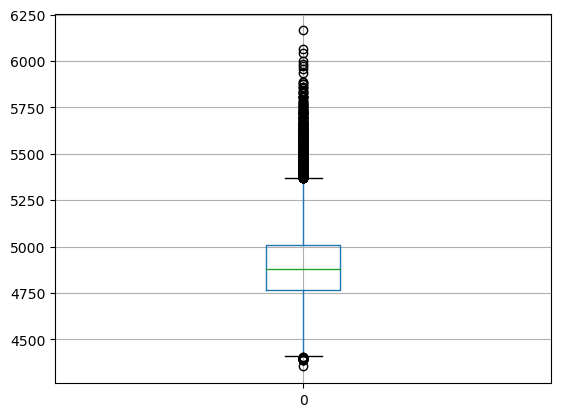

In [6]:
pres_abs_df.sum(axis='rows').to_frame().boxplot()

In [38]:
GOIS_min_identity = .5
GOIS_min_coverage = .8
ABRICATE_WANTED_COLS = (
    'SEQUENCE',
    'GENE',
    '%COVERAGE',
    '%IDENTITY',
    'DATABASE',
    'RESISTANCE'
)

REPAROMA_WANTED_COLS = (
    'query',
    'target',
    'pident',
    'qcov',
    'tcov',
    'DATABASE'
)

abricate_gois = (
    # Reading the ARBRICATE tables
    pd.concat(
        map(lambda fn: abricate_parser(fn), (AMR_table, VF_table)),
        ignore_index=True
    )
    # Filtering for identity and coverage 
    .loc[
        lambda df_: ( df_['%COVERAGE'].ge(GOIS_min_coverage * 100) ) &  (df_['%IDENTITY'].ge(GOIS_min_identity * 100))
    ]
    #
    .groupby(['SEQUENCE', 'DATABASE'], as_index=False)
    .apply(pd.DataFrame.head, n=1)
    .reset_index(drop=True)
    .loc[:, ABRICATE_WANTED_COLS]
)

In [47]:
mmseqs_gois = (
    # Reading the REPAROME AND MOBILOME
    pd.concat(
        map(
            lambda fn: (
                parse_mmseqs(fn).assign(DATABASE = Path(fn).stem)
            ),
            (reparoma_table, mobiloma_table)
        ),
        ignore_index=True
    )
    # Filtering for identity and coverage
    .loc[
        lambda df_: df_[['qcov', 'tcov']].ge(GOIS_min_coverage).all(axis='columns') & df_.pident.ge(GOIS_min_identity * 100)
        # ( df_[['qcov', 'tcov']].ge(GOIS_min_coverage).all(axis='columns') & df_.pident.ge(GOIS_min_identity) )
    ]
    .groupby(['query', 'DATABASE'])
    .apply(pd.DataFrame.head, n=1)
    .reset_index(drop=True)
    .loc[:, REPAROMA_WANTED_COLS]
    .assign(cov = lambda df_: df_[['qcov', 'tcov']].mean(axis=1))
    .loc[:, ['query', 'target', 'pident', 'cov', 'DATABASE']]
)

In [45]:
abricate_gois.head()

,SEQUENCE,GENE,%COVERAGE,%IDENTITY,DATABASE,RESISTANCE
0,0mNc1Rd9_49350,ANT(3'')-Ii-AAC(6')-IId_fusion_protein,100.00,93.46,card,aminoglycoside
1,0oa37Bwq_58190,mdtB,99.90,81.05,card,aminocoumarin
2,0rFSOPAb_52960,dfrA14,100.00,99.79,card,diaminopyrimidine
3,1jqtclVT_55020,AAC(6')-Ia,100.00,99.82,card,aminoglycoside
4,22LlKmzz_19030,APH(4)-Ia,81.97,100.00,card,aminoglycoside


In [59]:
GOIs_df = (
    pd.concat(
        map(
            lambda df_: df_.loc[:, ['query', 'target', 'database']],
            (
                abricate_gois.rename(columns=dict(zip(('SEQUENCE', 'GENE', 'DATABASE'), ('query', 'target', 'database')))),
                mmseqs_gois.rename(columns={'DATABASE' : 'database'})
            )
        ),
        ignore_index=True
    )
)

GOIs_df.head()

,query,target,database
0,0mNc1Rd9_49350,ANT(3'')-Ii-AAC(6')-IId_fusion_protein,card
1,0oa37Bwq_58190,mdtB,card
2,0rFSOPAb_52960,dfrA14,card
3,1jqtclVT_55020,AAC(6')-Ia,card
4,22LlKmzz_19030,APH(4)-Ia,card


In [83]:
GOIs_df.database.value_counts()

mobiloma    11888
reparoma     1433
card          206
vfdb           75
Name: database, dtype: int64

In [91]:
pres_abs_sliced_df = pres_abs_df.loc[lambda df_: df_.index.isin(set(GOIs_df['query'].unique()))]
print(pres_abs_sliced_df.shape)
pres_abs_sliced_df.head()

(12988, 15558)


,GCF_000427015.1_kleoxysa2,GCF_001052235.1_ASM105223v1,GCF_001052825.1_ASM105282v1,GCF_001053665.1_ASM105366v1,GCF_001054995.1_ASM105499v1,GCF_001060405.1_ASM106040v1,GCF_001065765.1_ASM106576v1,GCF_001066775.1_ASM106677v1,GCF_001070955.1_ASM107095v1,GCF_001072735.1_ASM107273v1,...,573.13358,573.13419,573.13484,573.13647,573.13649,573.14059,573.14170,573.14328,573.14387,573.14410
genes,,,,,,,,,,,,,,,,,,,,,
dL2MX9RY_32460,False,True,True,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
pYUsvLj2_02530,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
YhNf5LmV_31040,False,False,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
3XTiK9Uo_32380,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,True,False,False,False
cvvvrhwy_56310,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False


In [224]:
def add_species(df, species):
    new_df = df.copy()
    new_df.columns = pd.MultiIndex.from_tuples(tuple(zip((cols := new_df.columns).map(species), cols)), names=('species', 'genomes'))
    return new_df


pres_abs_species_df = (
    add_species(pres_abs_df, species)
    .groupby('species', axis=1)
    .apply(pd.DataFrame.sum, axis=1)
    .applymap(bool)
    .applymap(int)
)

    


In [225]:
pres_abs_species_df.head()

species,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
genes,,,,,,,
Ip6VPycV_48830,0,0,0,0,0,0,1
Ip6VPycV_49470,0,0,0,0,0,1,1
tU8ghtab_60870,0,1,1,0,1,1,1
Ip6VPycV_50110,0,0,0,0,1,1,1
Ip6VPycV_50430,0,0,0,0,0,0,1


In [284]:
pres_abs_species_perc_df = (
    add_species(pres_abs_df, species)
    .groupby('species', axis=1)
    .apply(lambda df_: (df_.sum(axis=1) / df_.shape[1]) * 100)
)

In [252]:
temp = add_species(pres_abs_df, species).sample(10)

In [277]:
temp.head(1).groupby('species', axis=1).agg(lambda df_: df_.shape[1]).reset_index().T[0].to_dict()

{'genes': 'uwSAlwfG_53270',
 'Klebsiella grimontii': 162,
 'Klebsiella michiganensis': 335,
 'Klebsiella oxytoca': 212,
 'Klebsiella pasteurii': 37,
 'Klebsiella pneumoniae': 13573,
 'Klebsiella quasipneumoniae': 671,
 'Klebsiella variicola': 568}

In [283]:
pres_abs_species_df.shape

(109408, 7)

In [294]:
GOIs_df.loc[lambda df_: df_.database.eq('reparoma')]

,query,target,database
282,00SnrgcH_46610,enx:NI40_018725,reparoma
284,00oLeWUr_30690,kpr:KPR_2275,reparoma
293,03Ohzhgj_10620,ecf:ECH74115_1671,reparoma
314,03Ohzhgj_27720,P76318,reparoma
316,03Ohzhgj_27860,manc:IV454_07935,reparoma
...,...,...,...
13525,zXMxvSeE_59430,B8X8Z0,reparoma
13531,zcOwpZbO_14260,Q8ZMG2,reparoma
13544,zeIzjz7w_48170,P9WNN1,reparoma
13577,zp7LgLM5_26750,P33136,reparoma


In [334]:
KO_list = (
    pd.read_csv(
        StringIO('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/parts/KO_gene_id'))),
        names=('KO', 'id'),
        header=None,
        sep=','
    )
    .drop_duplicates()
    .merge(
        pd.read_csv(
            StringIO('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/parts/KO_names'))),
            names=('KO', 'gene'),
            header=None,
            sep=';'
        ).drop_duplicates(),
        on='KO'
    )
)



In [448]:
GOIS_REPAROMA = (
    GOIs_df
    .loc[lambda df_: df_.database.eq('reparoma')]
    .merge(
        KO_list,
        left_on='target',
        right_on='id',
#         validate='m:1'
    )
    .loc[:, ['query', 'gene']]
    .rename(columns={'gene' : 'target'})
)

GOIS_REPAROMA.head()

,query,target
0,00SnrgcH_46610,uvrA
1,5s6tZU6x_35620,uvrA
2,00oLeWUr_30690,cho
3,03Ohzhgj_10620,umuC
4,03Ohzhgj_27860,lhr


In [458]:
temp = (
    pres_abs_species_df
    .loc[lambda df_: df_.index.isin(GOIS_REPAROMA['query'])]
    .merge(
        GOIS_REPAROMA,
        left_on='genes',
        right_on='query',
        validate='m:1',
    )
    .set_index(['target', 'query'])
    .groupby('target')
    .sum()
    .applymap(bool)
    .applymap(int)
)

temp.head(20)

,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
target,,,,,,,
"E1.17.4.1A, nrdA, nrdE",1,1,1,1,1,1,1
"E1.17.4.1B, nrdB, nrdF",1,1,1,1,1,1,1
"E3.1.11.2, xthA",1,1,1,1,1,1,1
"E3.1.21.7, nfi",1,1,1,1,1,1,1
"E6.5.1.2, ligA, ligB",1,1,1,1,1,1,1
NTH,1,1,1,1,1,1,1
"UNG, UDG",1,1,1,1,1,1,1
ada,1,1,1,1,1,1,1
alkA,1,1,1,1,1,1,1


In [386]:
gene_names.drop_duplicates().shape

(800660, 2)

In [391]:
pres_abs_species_df.head()

species,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
genes,,,,,,,
Ip6VPycV_48830,0,0,0,0,0,0,1
Ip6VPycV_49470,0,0,0,0,0,1,1
tU8ghtab_60870,0,1,1,0,1,1,1
Ip6VPycV_50110,0,0,0,0,1,1,1
Ip6VPycV_50430,0,0,0,0,0,0,1


In [494]:
import json

for i in json.loads('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/ko03400.json')))['children'][0]['children']:
    for y in i['children']:
        print(y['name'])

Direct repair
BER (base exicision repair)
NER (nucleotide excision repair)
MMR (mismatch excision repair)
HR (homologous recombination)
NHEJ (non-homologous end-joining)
FA (Fanconi anemia) pathway
Other DSBR factors
Y-family DNA polymerases
B-family DNA polymerases
A-family DNA polymerase
Rad6 epistasis group
Other TLS factors
Rad9-Hus1-Rad1 complex
HRAD17(Rad24)-RFC complex
Rad17-Mec3-Ddc1 complex
FPC (fork protection complex)
Triple T complex
BAG6-UBL4A-GET4 complex
Other check point factors
DNA polymerases
Nucleases
Helicases
PSO4 complex
Modulation of nucleotide pools


In [549]:
def expand_kegg_record(rec):
    if not (children := rec.get('children')):
        return rec['name']
    print(*map(expand_kegg_record, children), sep='\t')
        
    
expand_kegg_record(json.loads('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/ko03400.json')))['children'][1])

K00567  ogt, MGMT; methylated-DNA-[protein]-cysteine S-methyltransferase [EC:2.1.1.63]	K10778  ada; AraC family transcriptional regulator, regulatory protein of adaptative response / methylated-DNA-[protein]-cysteine methyltransferase [EC:2.1.1.63]	K13530  adaA; AraC family transcriptional regulator, regulatory protein of adaptative response / methylphosphotriester-DNA alkyltransferase methyltransferase [EC:2.1.1.-]	K13531  adaB; methylated-DNA-[protein]-cysteine S-methyltransferase [EC:2.1.1.63]	K01669  phr, PHR1; deoxyribodipyrimidine photo-lyase [EC:4.1.99.3]	K06876  phrB; (6-4)DNA photolyase [EC:4.1.99.13]	K03919  alkB; DNA oxidative demethylase [EC:1.14.11.33]
K03648  UNG, UDG; uracil-DNA glycosylase [EC:3.2.2.27]	K03649  mug; double-stranded uracil-DNA glycosylase [EC:3.2.2.28]	K10800  SMUG1; single-strand selective monofunctional uracil DNA glycosylase [EC:3.2.2.-]	K21929  udg; uracil-DNA glycosylase [EC:3.2.2.27]	K01247  alkA; DNA-3-methyladenine glycosylase II [EC:3.2.2.21]	K1

In [557]:
def expand_kegg_record(json_obj):
    paths = []
    def dfs(node, path):
        if not node.get("children"):
            paths.append(path + [node["name"]])
            return
        for child in node["children"]:
            dfs(child, path + [node["name"]])
    dfs(json_obj, [])
    return paths

recs = expand_kegg_record(json.loads('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/ko03400.json')))['children'][1])




In [675]:
# kegg_KO_proka = (
#     pd.DataFrame([ rec + ([None] * (6 - len(recs))) for rec in recs ])
#     .iloc[:, 1:]
#     .fillna('')
#     .assign(
#         KO = lambda df_: df_.apply(lambda x: tuple(filter(lambda y: y.startswith('K'), x))[0], axis=1),
#         cats = lambda df_: df_.apply(lambda x: list(filter(lambda y: not y.startswith('K'), x)), axis=1),
#     )
#     .loc[:, ['cats', 'KO']]
#     .pipe(lambda df_: pd.concat((pd.DataFrame(df_.cats.values.tolist()), df_.KO), axis=1, ignore_index=True) )
#     .assign(
#         KO = lambda df_: df_[4].str.split().str[0],
#         name = lambda df_: df_[4].str.split(';').str[0].str.split().apply(lambda x: ' '.join(x[1:])),
#         description = lambda df_: df_[4].str.split(';').str[1],
#         categorie = lambda df_: df_.loc[:, :3].agg('; '.join, axis=1)
#     )
#     .loc[:, lambda df_: ~df_.columns.to_series().str.isdigit().apply(bool) ]
# )

kegg_KO_proka.head()

,KO,name,description,categorie
0,K00567,"ogt, MGMT",methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
1,K10778,ada,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
2,K13530,adaA,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
3,K13531,adaB,methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
4,K01669,"phr, PHR1",deoxyribodipyrimidine photo-lyase [EC:4.1.99.3],SSBR (single strand breaks repair); Direct rep...


In [696]:
kofamkoala_results = pd.read_csv('/home/hugo.avila/Projects/reparoma/results/GOIs/reparome/kofamkoala.tsv', sep='\t', header=None, names=('locus_tag', 'KO'))
kofamkoala_results.head()

,locus_tag,KO
0,00SnrgcH_46610,K03701
1,00oLeWUr_30690,K05984
2,03Ohzhgj_10620,K03502
3,03Ohzhgj_27860,K03724
4,07iiMt1j_53790,K07677


In [1108]:
kegg_KO_proka

,KO,name,description,categorie
0,K00567,"ogt, MGMT",methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
1,K10778,ada,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
2,K13530,adaA,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
3,K13531,adaB,methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
4,K01669,"phr, PHR1",deoxyribodipyrimidine photo-lyase [EC:4.1.99.3],SSBR (single strand breaks repair); Direct rep...


In [723]:
(
    kofamkoala_results
    .pipe(lambda df_: pres_abs_species_df.loc[lambda x: x.index.isin(df_.locus_tag.unique())])
#     .assign(gene_name = lambda df_: df_.index.map() )
)

species,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
genes,,,,,,,
unfP0Olg_52910,1,1,0,0,1,1,1
SJSLYR4C_26260,1,1,1,1,1,1,1
BXSVOeZY_50730,1,1,1,1,1,1,1
qms7Pha9_30520,1,1,1,1,1,1,1
KnqModvt_51580,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...
9t18POB5_22090,0,0,1,0,0,0,0
9t18POB5_49730,0,0,1,0,0,0,0
9t18POB5_55900,0,0,1,0,0,0,0


In [1326]:
import matplotlib.pyplot as plt

def get_clustermap(df, figsize=(4, 20), cmap="Spectral"):
    g = sns.clustermap(
            df,
            cmap=cmap,
            dendrogram_ratio=(.1, .02),
            figsize=figsize,
            vmin=0, vmax=1,
            xticklabels=True, yticklabels=True,
            square=True,
            cbar=False,
            linewidths=.05,
            cbar_pos=(.0002, .32, .03, .2),
            col_cluster=False
        )
    
    plt.close()
    return g.data2d

# get_clustermap(reparoma_map_data)

In [1164]:

def process_abricate(main_table, db):
    return (
        main_table
        .loc[lambda df_: df_.database.eq(db)]
        .drop('database', axis=1)
        .pipe(
            lambda df_: (
                pres_abs_species_df
                .loc[lambda x: x.index.isin(df_['query'])]
                .merge(
                    df_,
                    left_on='genes',
                    right_on='query',
                    validate='1:m'
                )
            )
        )
        .pipe(
            lambda df_: (
                df_.set_index(['query', 'target'])
                .groupby('target')
                .sum()
                .assign(genes = lambda df__: df__.index + df__.index.map(
                    df_.loc[:, ['query', 'target']].groupby('target').agg(len)['query'].apply(lambda x: f' ({x})' if x > 1 else '' ).to_dict()
                ))
            )
        )
        .set_index('genes')
    )

# get_clustermap(process_abricate(GOIs_df, 'vfdb'))

In [991]:
get_clustermap(process_abricate(GOIs_df, 'card'), figsize=(3, 35))# .savefig("/home/hugo.avila/Projects/reparoma/clustermap.svg", dpi=300)

/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
genes,,,,,,,
SIM-1_beta-lactamase,0,1,0,0,0,1,0
VEB-3,0,1,0,0,1,1,0
linG,0,1,0,0,1,1,0
TLA-3,0,1,0,0,0,0,0
dfrB4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
APH(3'')-Ib (2),2,2,2,2,2,2,2
dfrA1 (3),1,1,1,0,3,0,1
mphA (3),0,1,1,1,3,1,1


/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


,DATABASE,GENE,SEQUENCE,ACCESSION,PRODUCT,RESISTANCE,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
0,card,OXY-1-1,S1KkZPYk_28150,Z30177:348-1224,OXY-1-1 is a beta-lactamase found in Klebsiell...,cephalosporin monobactam penam,1,1,1,1,0,0,1
1,card,CTX-M-24,SDnIFicM_07920,AY143430:0-876,CTX-M-24 is a beta-lactamase found in the Ente...,cephalosporin,1,0,1,1,1,0,1
2,card,SHV-160,j2W9bo3P_51320,JX121127:0-861,SHV-160 is a beta-lactamase.,carbapenem cephalosporin penam,1,1,1,1,1,0,1
3,card,dfrA1,tb3CfCyv_55490,KJ541681.1:19526-20000,dfrA1 is an integron-encoded dihydrofolate red...,diaminopyrimidine,1,1,1,0,1,0,1
4,card,SAT-1,TS47NdSr_16930,AB211124:0-525,SAT-2 is a plasmid-mediated streptothricin ace...,nucleoside,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,vfdb,fepC,ryYy6gj5_38680,NP_752606,(fepC) ferrienterobactin ABC transporter ATPas...,NA,1,1,1,1,1,1,1
277,vfdb,yagX/ecpC,iH7gBhZS_45380,NP_286008,(yagX/ecpC) E. coli common pilus usher EcpC [E...,NA,1,1,1,1,1,1,1
278,vfdb,ybtT,w0JNU3WN_18640,NP_405469,(ybtT) yersiniabactin biosynthetic protein Ybt...,NA,1,1,1,1,1,1,1
279,vfdb,yagZ/ecpA,vFEGvHO5_38640,NP_286010,(yagZ/ecpA) E. coli common pilus structural su...,NA,1,1,1,1,1,1,1


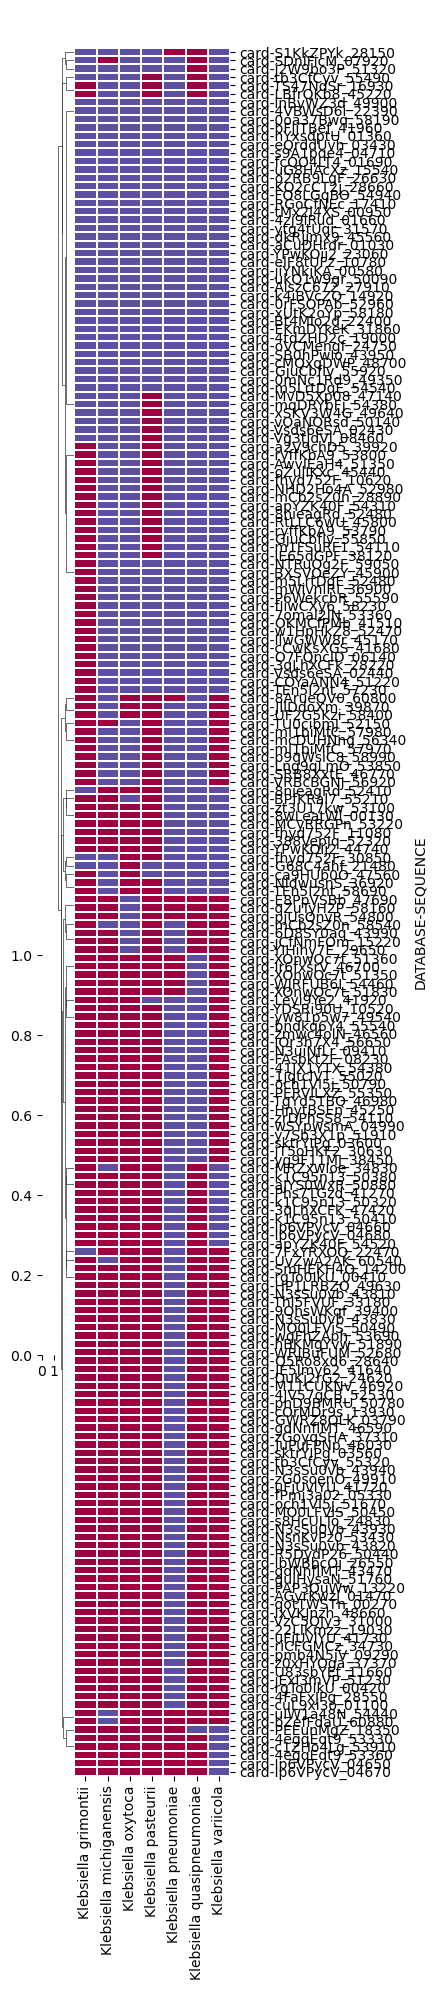

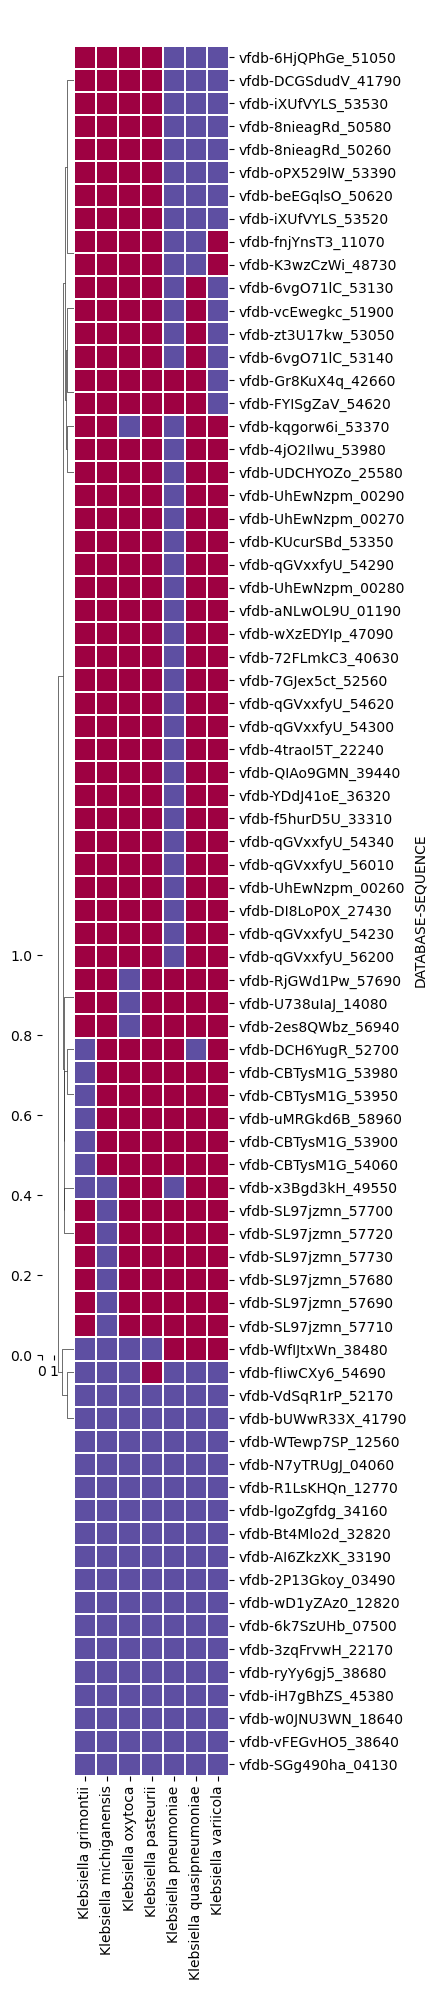

In [1280]:
ABRICATE_WANTED_COLS = (
    'SEQUENCE',
    'GENE',
    '%COVERAGE',
    '%IDENTITY',
    'DATABASE',
    'ACCESSION',
    'PRODUCT',
    'RESISTANCE',
)

ABRICATE_ORDER = (
    'DATABASE',
    'GENE',
    'SEQUENCE',
    'ACCESSION',
    'PRODUCT',
    'RESISTANCE',
    'Klebsiella grimontii',
    'Klebsiella michiganensis',
    'Klebsiella oxytoca',
    'Klebsiella pasteurii',
    'Klebsiella pneumoniae',
    'Klebsiella quasipneumoniae',
    'Klebsiella variicola',
)

(
    pd.concat(    
        map(lambda fn: pd.read_csv(fn, sep='\t'), (AMR_table, VF_table)),
        ignore_index=True,
    )
    .loc[:, ABRICATE_WANTED_COLS]
    .loc[lambda df_: df_['%COVERAGE'].ge(80) & df_['%IDENTITY'].ge(50)]
    .groupby(['SEQUENCE', 'DATABASE'], as_index=False)
    .apply(pd.DataFrame.head, n=1)
    .reset_index(drop=True)
    .drop(['%COVERAGE', '%IDENTITY'], axis=1)
    .pipe(
        lambda df_: (
            df_
            .fillna('NA')
            .groupby(['GENE', 'DATABASE'])
            .agg(lambda series_: ';'.join(set(series_)))
            .reset_index()
            .drop('SEQUENCE', axis=1)
            .merge(
                df_.loc[:, ['SEQUENCE', 'GENE']],
                on='GENE',
                validate='1:m'
            )
        )
    )
    .pipe(
        lambda df_: (
            df_.groupby(['DATABASE'])
            .apply(lambda gdf_: pres_abs_species_df.loc[lambda x: x.index.isin(gdf_.SEQUENCE)])
            .merge(
                df_,
                left_on=('DATABASE', 'genes'),
                right_on=('DATABASE', 'SEQUENCE'),
                validate='1:1'
            )
        )
    )
    .pipe(
        lambda df_: (
            df_.set_index(['DATABASE', 'SEQUENCE'])
            .loc[:, lambda x: list(x.columns.str.startswith('Kleb'))]
            .groupby('DATABASE', as_index=None)
            .apply(get_clustermap)
            .reset_index()
            .drop('level_0', axis=1)
            .merge(
                df_.loc[:, lambda x: list(~x.columns.str.startswith('Kleb'))],
                on=('DATABASE', 'SEQUENCE'),
                validate='1:1'
            )
        )
    )
    .loc[:, ABRICATE_ORDER]
    .assign(RESISTANCE = lambda df_: df_.RESISTANCE.str.replace(';', ' ') )
#     .to_csv('/home/hugo.avila/Projects/reparoma/results/GOIs/abricate/ABRICATE.tsv', index=False, sep='\t')
    
)


In [1109]:
(
    kegg_KO_proka
    .
    .head()
)

,KO,name,description,categorie
0,K00567,"ogt, MGMT",methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
1,K10778,ada,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
2,K13530,adaA,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
3,K13531,adaB,methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
4,K01669,"phr, PHR1",deoxyribodipyrimidine photo-lyase [EC:4.1.99.3],SSBR (single strand breaks repair); Direct rep...


In [1180]:
(
    pd.read_csv(
        '/home/hugo.avila/Projects/reparoma/results/GOIs/reparome/mmseqs/reparoma_kegg.tsv',
        sep='\t',
        header=None,
        names='query,target,pident,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qcov,tcov'.split(',')
    )
    .loc[lambda df_: df_[['qcov', 'tcov']].ge(.8).all(axis=1) & df_.pident.ge(50) ]
    .groupby('query', as_index=False)
    .apply(pd.DataFrame.head, n=1)
    [['query']]
    .to_csv('/home/hugo.avila/Projects/reparoma/results/GOIs/reparome/mmseqs/match_ids.txt', sep='\t', header=None, index=False)
)

/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


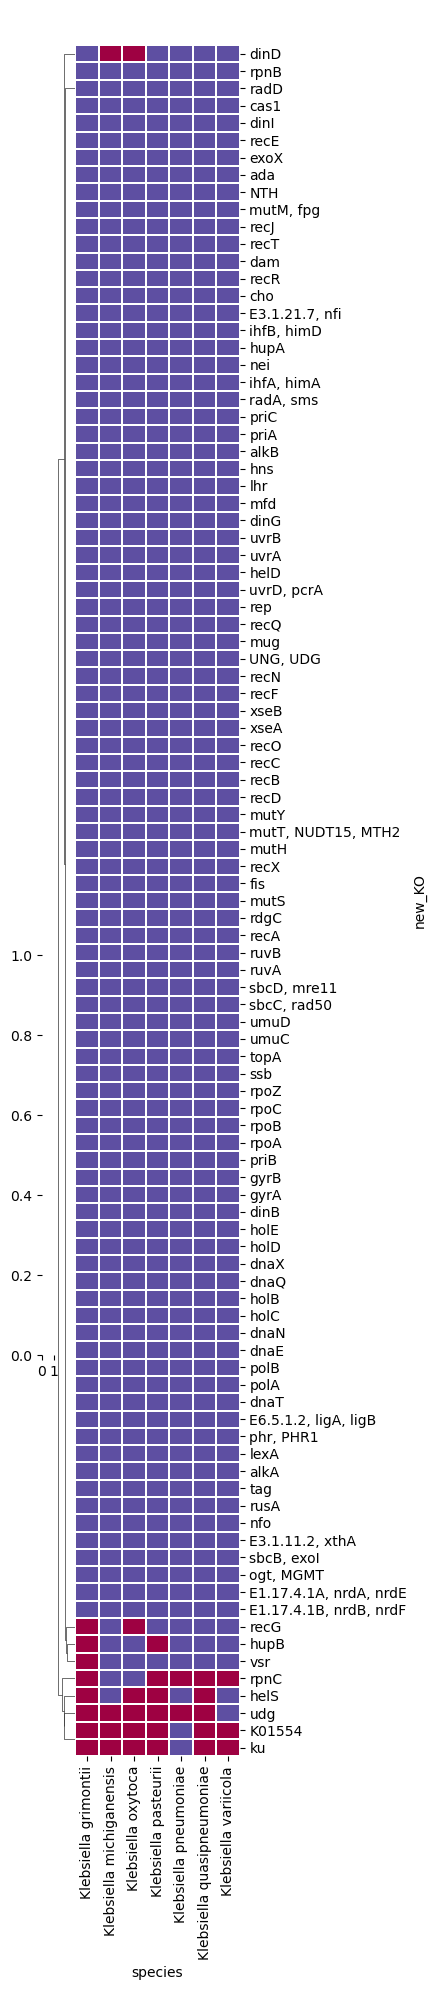

In [1172]:
# get_clustermap()
get_clustermap(temp.assign(new_KO = lambda df_: df_.index.map(kegg_KO_proka.set_index('KO')['name'].to_dict() )).set_index('new_KO'))

In [1289]:
reparoma_map_data = (
    pd.DataFrame(
        map(lambda x: ((l := x.split())[1], l[2], ' '.join(l[6:])) , filter(lambda x: not x[0] == '#', read_file('/home/hugo.avila/Projects/reparoma/results/GOIs/kofam/result.txt'))),
        columns=['locus_tag', 'KO', 'product'],
    )
    .drop('product', axis=1)
    .merge(
        (
            pd.read_csv(
                '/home/hugo.avila/Projects/reparoma/results/GOIs/kofam/ko_names.txt',
                sep='\t',
                header=None,
                names=('KO', 'product')
            )
            .assign(
                KO = lambda df_: df_.KO.str.replace('ko:', ''),
                gene_name = lambda df_: df_['product'].str.split(';').str[0],
                product = lambda df_: df_['product'].str.split(';').str[1],
            )
        ),
        on='KO',
        validate='m:1'
    )
    .pipe(
        lambda df_: (
            pres_abs_species_df
            .loc[lambda x: x.index.isin(df_.locus_tag.unique())]
            .assign(KO = lambda x: x.index.map(df_[['locus_tag', 'KO']].set_index('locus_tag').KO.to_dict()))
            .groupby('KO')
            .sum()
            .applymap(bool)
            .applymap(int)
            .merge(
                df_.groupby('KO').agg(lambda series_: '; '.join(set(series_))),
                on='KO',
                validate='1:1'
            )
        )
    )
#     .pipe(
#         lambda df_: (
#             df_.loc[df_.loc[:, df_.columns.str.startswith('Kleb')].pipe(get_clustermap).index.values]
#         )
#     )
)

In [1296]:
kegg_KO_proka.drop('description', axis=1)

,KO,name,categorie
0,K00567,"ogt, MGMT",SSBR (single strand breaks repair); Direct rep...
1,K10778,ada,SSBR (single strand breaks repair); Direct rep...
2,K13530,adaA,SSBR (single strand breaks repair); Direct rep...
3,K13531,adaB,SSBR (single strand breaks repair); Direct rep...
4,K01669,"phr, PHR1",SSBR (single strand breaks repair); Direct rep...
...,...,...,...
152,K01520,"dut, DUT",Other factors with a suspected DNA repair func...
153,K00525,"E1.17.4.1A, nrdA, nrdE",Other factors with a suspected DNA repair func...
154,K00526,"E1.17.4.1B, nrdB, nrdF",Other factors with a suspected DNA repair func...
155,K06881,nrnA,Other factors with a suspected DNA repair func...


In [1329]:
(
    kegg_KO_proka.drop('description', axis=1)
    .groupby('categorie')
    .apply(
        lambda gdf_: (
            reparoma_map_data.loc[:, lambda df_: df_.columns.str.startswith('Kleb')]
            .merge(
                gdf_,
                on='KO',
                how='right',
                validate='1:1'
            )
        )
    )
    .set_index(['categorie', 'KO','name'])
    .fillna(0)
    .groupby('categorie', as_index=False)
    .apply(lambda df_: df_.pipe(get_clustermap) if df_.shape[0] > 1 else df_ )
)

# reparoma_map_data.loc[:, lambda df_: df_.columns.str.startswith('Kleb')]

/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:615: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, max_dependent_coord * 1.05)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Klebsiella grimontii  \
   categorie                                          KO     name                                
0  DSBR (double strand breaks repair); HR (homolog... K16898 addA                          0.0   
                                                      K16899 addB                          0.0   
1  DSBR (double strand breaks repair); HR (homolog... K03546 sbcC, rad50                   1.0   
                                                      K03547 sbcD, mre11                   1.0   
                                                      K03726 helS                          0.0   
...                                                                                        ...   
31 TLS (translesion DNA synthesis) factors; Other ... K14161 imuB                          0.0   
32 TLS (translesion DNA synthesis) factors; Y-fami... K04479 dbh                           0.0   
                                                      K03503 umuD                          1.0   
                                                      K02346 dinB                          1.0   
                                                      K03502 umuC                          1.0   

                                                                          Klebsiella michiganensis  \
   categorie                                          KO     name                                    
0  DSBR (double strand breaks repair); HR (homolog... K16898 addA                              0.0   
                                                      K16899 addB                              0.0   
1  DSBR (double strand breaks repair); HR (homolog... K03546 sbcC, rad50                       1.0   
                                                      K03547 sbcD, mre11                       1.0   
                                                      K03726 helS                              0.0   
...                                                                                            ...   
31 TLS (translesion DNA synthesis) factors; Other ... K14161 imuB                              0.0   
32 TLS (translesion DNA synthesis) factors; Y-fami... K04479 dbh                               0.0   
                                                      K03503 umuD                              1.0   
                                                      K02346 dinB                              1.0   
                                                      K03502 umuC                              1.0   

                                                                          Klebsiella oxytoca  \
   categorie                                          KO     name                              
0  DSBR (double strand breaks repair); HR (homolog... K16898 addA                        0.0   
                                                      K16899 addB                        0.0   
1  DSBR (double strand breaks repair); HR (homolog... K03546 sbcC, rad50                 1.0   
                                                      K03547 sbcD, mre11                 1.0   
                                                      K03726 helS                        0.0   
...                                                                                      ...   
31 TLS (translesion DNA synthesis) factors; Other ... K14161 imuB                        0.0   
32 TLS (translesion DNA synthesis) factors; Y-fami... K04479 dbh                         0.0   
                                                      K03503 umuD                        1.0   
                                                      K02346 dinB                        1.0   
                                                      K03502 umuC                        1.0   

                                                                          Klebsiella pasteurii  \
   categorie                                          KO     name                                
0  DSBR (double strand brea

In [1310]:
reparoma_map_data.loc[:, lambda df_: df_.columns.str.startswith('Kleb')].head()

,Klebsiella grimontii,Klebsiella michiganensis,Klebsiella oxytoca,Klebsiella pasteurii,Klebsiella pneumoniae,Klebsiella quasipneumoniae,Klebsiella variicola
KO,,,,,,,
K00020,1,1,1,1,1,1,1
K00052,1,1,1,1,1,1,1
K00065,1,1,1,1,1,1,1
K00104,0,0,0,0,1,0,0
K00108,1,1,1,1,1,1,1


In [1330]:
temp = _


In [1421]:
(
    temp
    .applymap(int)
    .reset_index()
    .drop('level_0', axis=1)
    .pipe(
        lambda df_: pd.concat(
            (
                df_,
                (
                    df_
                    .categorie
                    .str.split('; ', expand=True)
                    .replace(pd.read_csv('/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/kegg_trans.tsv', sep='\t', header=None).set_index(0)[1].to_dict())
                )
            ),
            axis=1
        )
    )
    .drop('categorie', axis=1)
    .set_index(list(range(4)))
    .assign(KO = lambda df_: df_[['name', 'KO']].agg(lambda x: '{} ({})'.format(*x), axis=1))
    .drop('name', axis=1)
).to_csv('/home/hugo.avila/Projects/reparoma/cat.tsv', sep='\t')

In [1374]:
(
    temp
    .reset_index()
    .groupby('categorie')
    .apply(lambda df_: df_.iloc[[0,-1]])
    .loc[:, ['categorie', 'KO']]
    .reset_index(drop=True)
    .loc[lambda df_: (c := df_.categorie).eq('Other factors with a suspected DNA repair function; Modulation of nucleotide pools; ; ')]
)

,categorie,KO
0,DSBR (double strand breaks repair); HR (homolo...,K16898
1,DSBR (double strand breaks repair); HR (homolo...,K16899
2,DSBR (double strand breaks repair); HR (homolo...,K03546
3,DSBR (double strand breaks repair); HR (homolo...,K04484
4,DSBR (double strand breaks repair); HR (homolo...,K15342
...,...,...
61,SSBR (single strand breaks repair); NER (nucle...,K03723
62,TLS (translesion DNA synthesis) factors; Other...,K14623
63,TLS (translesion DNA synthesis) factors; Other...,K14161
64,TLS (translesion DNA synthesis) factors; Y-fam...,K04479


In [1612]:
temp

species                                                               Klebsiella grimontii  \
genomes                                                          GCF_000427015.1_kleoxysa2   
categorie                                          KO                                        
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                         0   
                                                   addB (K16899)                         0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                         0   
                                                   radB (K04484)                         0   
                                                   hjr (K03552)                          0   
...                                                                                    ...   
TLS (translesion DNA synthesis) factors; Other ... rpnE (K24090)                         0   
TLS (translesion DNA synthesis) factors; Y-fami... dinB (K02346)                         1   
                                                   umuC (K03502)                         1   
                                                   umuD (K03503)                         1   
                                                   dbh (K04479)                          0   

species                                                                                       \
genomes                                                          GCF_001052235.1_ASM105223v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   
...                                                                                      ...   
TLS (translesion DNA synthesis) factors; Other ... rpnE (K24090)                           0   
TLS (translesion DNA synthesis) factors; Y-fami... dinB (K02346)                           1   
                                                   umuC (K03502)                           1   
                                                   umuD (K03503)                           1   
                                                   dbh (K04479)                            0   

species                                                                                       \
genomes                                                          GCF_001052825.1_ASM105282v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   
...                                                                                      ...   
TLS (translesion DNA synthesis) factors; Other ... rpnE (K24090)                           0   
TLS (translesion DNA synthesis) factors; Y-fami... dinB (K02346)                           1   
                                                   umuC (K03502)                           1   
                                                   umuD (K03503)                           1   
                                                   dbh (K04479)                           

In [1427]:
(
    kegg_KO_proka.drop('description', axis=1)
    .groupby('categorie')
    .apply(
        lambda gdf_: (
            reparoma_map_data.loc[:, lambda df_: df_.columns.str.startswith('Kleb')]
            .merge(
                gdf_,
                on='KO',
                how='right',
                validate='1:1'
            )
        )
    )
    .set_index(['categorie', 'KO','name'])
    .fillna(0)
#     .groupby('categorie', as_index=False)
#     .apply(lambda df_: df_.pipe(get_clustermap) if df_.shape[0] > 1 else df_ )
)

Klebsiella grimontii  \
categorie                                          KO     name                         
DSBR (double strand breaks repair); HR (homolog... K16898 addA                   0.0   
                                                   K16899 addB                   0.0   
DSBR (double strand breaks repair); HR (homolog... K04483 radA                   0.0   
                                                   K04484 radB                   0.0   
                                                   K03552 hjr                    0.0   
...                                                                              ...   
TLS (translesion DNA synthesis) factors; Other ... K24090 rpnE                   0.0   
TLS (translesion DNA synthesis) factors; Y-fami... K02346 dinB                   1.0   
                                                   K03502 umuC                   1.0   
                                                   K03503 umuD                   1.0   
                                                   K04479 dbh                    0.0   

                                                                Klebsiella michiganensis  \
categorie                                          KO     name                             
DSBR (double strand breaks repair); HR (homolog... K16898 addA                       0.0   
                                                   K16899 addB                       0.0   
DSBR (double strand breaks repair); HR (homolog... K04483 radA                       0.0   
                                                   K04484 radB                       0.0   
                                                   K03552 hjr                        0.0   
...                                                                                  ...   
TLS (translesion DNA synthesis) factors; Other ... K24090 rpnE                       0.0   
TLS (translesion DNA synthesis) factors; Y-fami... K02346 dinB                       1.0   
                                                   K03502 umuC                       1.0   
                                                   K03503 umuD                       1.0   
                                                   K04479 dbh                        0.0   

                                                                Klebsiella oxytoca  \
categorie                                          KO     name                       
DSBR (double strand breaks repair); HR (homolog... K16898 addA                 0.0   
                                                   K16899 addB                 0.0   
DSBR (double strand breaks repair); HR (homolog... K04483 radA                 0.0   
                                                   K04484 radB                 0.0   
                                                   K03552 hjr                  0.0   
...                                                                            ...   
TLS (translesion DNA synthesis) factors; Other ... K24090 rpnE                 0.0   
TLS (translesion DNA synthesis) factors; Y-fami... K02346 dinB                 1.0   
                                                   K03502 umuC                 1.0   
                                                   K03503 umuD                 1.0   
                                                   K04479 dbh                  0.0   

                                                                Klebsiella pasteurii  \
categorie                                          KO     name                         
DSBR (double strand breaks repair); HR (homolog... K16898 addA                   0.0   
                                                   K16899 addB                   0.0   
DSBR (double strand breaks repair); HR (homolog... K04483 radA                   0.0   
                                                   K04484 radB                   0.0   
                                                   K03552 hjr              

In [1426]:
add_species(pres_abs_df, species).head()

species             Klebsiella grimontii                              \
genomes        GCF_000427015.1_kleoxysa2 GCF_001052235.1_ASM105223v1   
genes                                                                  
Ip6VPycV_48830                     False                       False   
Ip6VPycV_49470                     False                       False   
tU8ghtab_60870                     False                       False   
Ip6VPycV_50110                     False                       False   
Ip6VPycV_50430                     False                       False   

species                                                                 \
genomes        GCF_001052825.1_ASM105282v1 GCF_001053665.1_ASM105366v1   
genes                                                                    
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 \
genomes        GCF_001054995.1_ASM105499v1 GCF_001060405.1_ASM106040v1   
genes                                                                    
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 \
genomes        GCF_001065765.1_ASM106576v1 GCF_001066775.1_ASM106677v1   
genes                                                                    
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 ...  \
genomes        GCF_001070955.1_ASM107095v1 GCF_001072735.1_ASM107273v1  ...   
genes                                                                   ...   
Ip6VPycV_48830                       False                       False  ...   
Ip6VPycV_49470                       False                       False  ...   
tU8ghtab_60870                       False                       False  ...   
Ip6VPycV_50110                       False                       False  ...   
Ip6VPycV_50430                       False                       False  ...   

species        Klebsiella variicola                                          \
genomes                   573.13358 573.13419 573.13484 573.13647 573.13649   
genes                                                                         
Ip6VPycV_48830                False     False     False     False     False   
Ip6VPycV_49470                False     False     False     False     False   
tU8ghtab_60870                 True     False     False     False     False   
Ip6VPycV_50110                False     False     False     False     False   
Ip6VPycV_50430                 True     False     False     False     False   

species                                                           
genomes        573.14059 573.14170 573.14328 573.14387 573.14410  
genes                                                             
Ip6VPycV_48830     False     False     False     False     False  
Ip6VPycV_49470     False     False     False     False     False  
tU8ghtab_60870     False     False     Fals

<AxesSubplot: xlabel='species-genomes', ylabel='categorie-KO'>

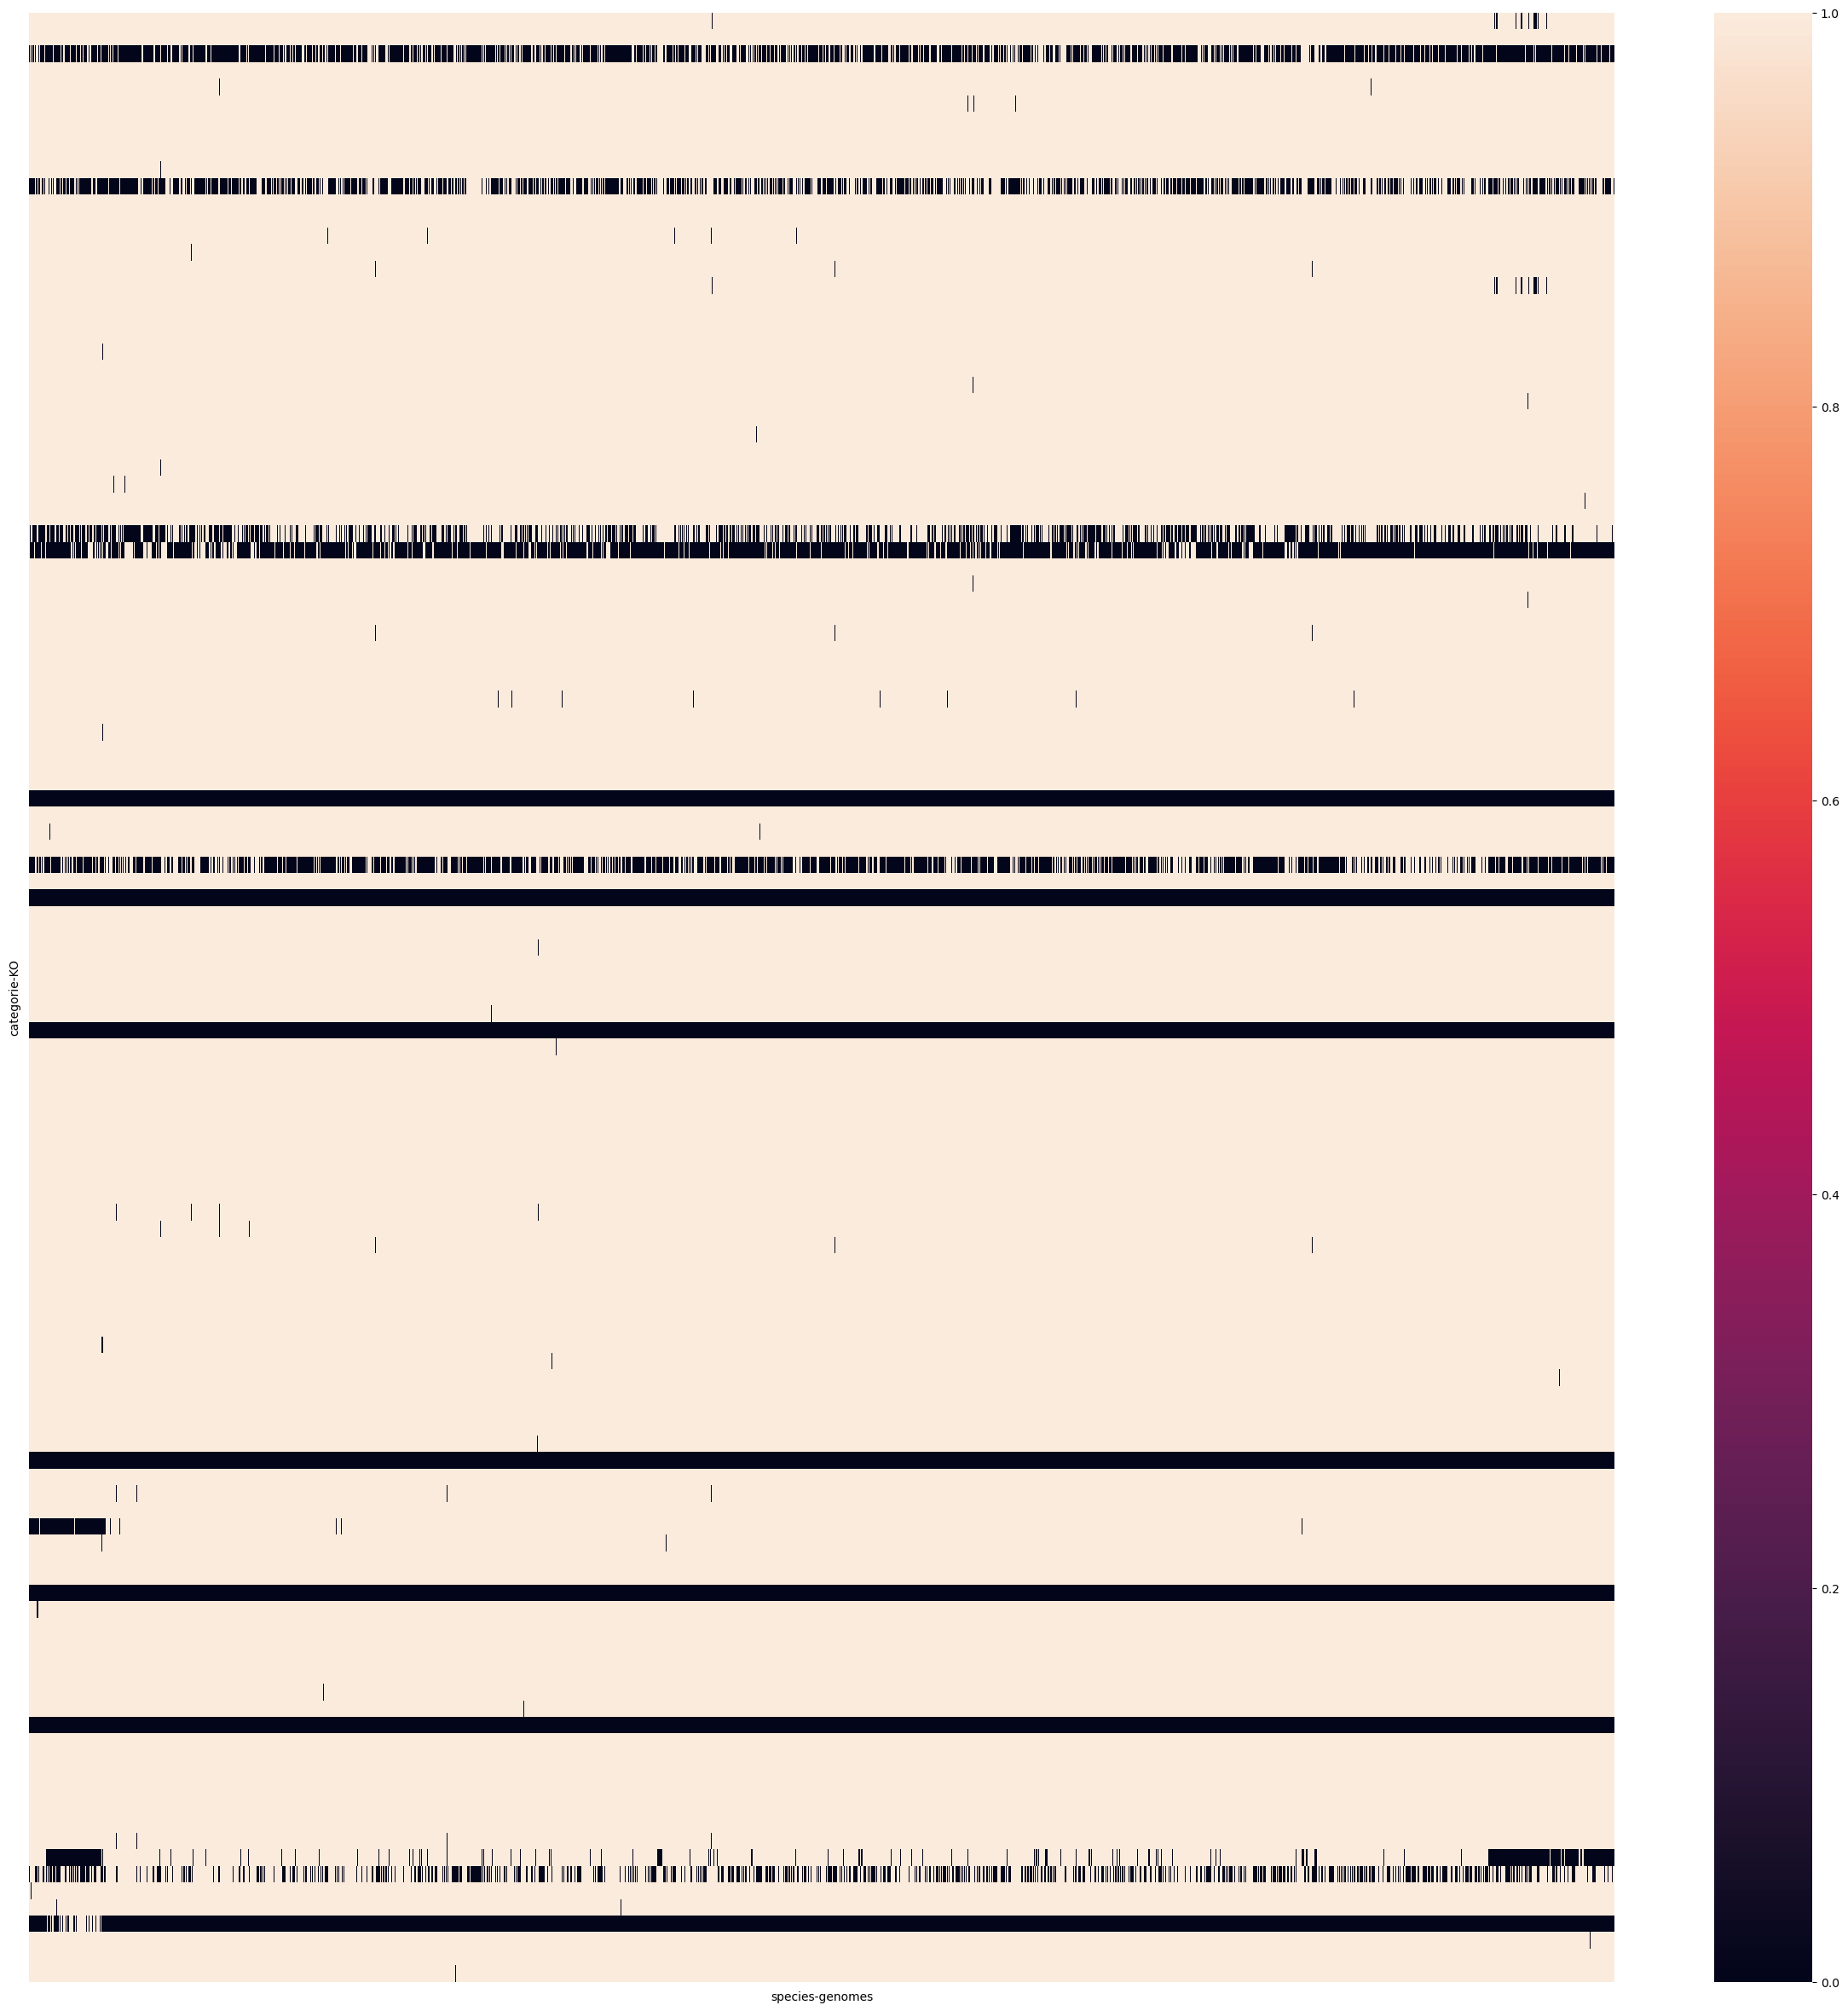

In [1541]:
plt.figure(figsize=(30, 30)) 
sns.heatmap(temp.loc[lambda df_: df_.any(axis=1)], xticklabels=False, yticklabels=False)

In [1553]:
print(*map('\t'.join ,pd.DataFrame(temp.loc[lambda df_: df_.any(axis=1)].index.to_frame().values).values), sep='\n')


DSBR (double strand breaks repair); HR (homologous recombination); Archaeal homologous recombinant proteins; 	sbcC, rad50 (K03546)
DSBR (double strand breaks repair); HR (homologous recombination); Archaeal homologous recombinant proteins; 	sbcD, mre11 (K03547)
DSBR (double strand breaks repair); HR (homologous recombination); Other HR factor; 	cas1 (K15342)
DSBR (double strand breaks repair); HR (homologous recombination); Other HR factor; 	radD (K19789)
DSBR (double strand breaks repair); HR (homologous recombination); RecBC pathway proteins; 	recB (K03582)
DSBR (double strand breaks repair); HR (homologous recombination); RecBC pathway proteins; 	recC (K03583)
DSBR (double strand breaks repair); HR (homologous recombination); RecBC pathway proteins; 	recD (K03581)
DSBR (double strand breaks repair); HR (homologous recombination); RecBC pathway proteins; 	recA (K03553)
DSBR (double strand breaks repair); HR (homologous recombination); RecBC pathway proteins; 	ruvA (K03550)
DSBR (doub

In [1569]:
from matplotlib.colors import to_hex

categories_pt = (
    'Recombinação homóloga (HR)',
    'Junção de extremidades não-homólogas (NHEJ)',
    'Outros fatores com função associada ao de reparo de DNA',
    'Reparo de excisão de base (BER)',
    'Reparo direto (RD)',
    'Reparo de desemparelhamento (MMR)',
    'Reparo de excisão de nucleotídeos (NER)',
    'Outros fatores de resposta SOS',
    'Polimerase de DNA (Y-family)'
)

{ k : to_hex(v) for k,v in zip(categories_pt, sns.color_palette("Set2", len(categories_pt))) }

{'Recombinação homóloga (HR)': '#66c2a5',
 'Junção de extremidades não-homólogas (NHEJ)': '#fc8d62',
 'Outros fatores com função associada ao de reparo de DNA': '#8da0cb',
 'Reparo de excisão de base (BER)': '#e78ac3',
 'Reparo direto (RD)': '#a6d854',
 'Reparo de desemparelhamento (MMR)': '#ffd92f',
 'Reparo de excisão de nucleotídeos (NER)': '#e5c494',
 'Outros fatores de resposta SOS': '#b3b3b3',
 'Polimerase de DNA (Y-family)': '#66c2a5'}

In [1579]:
co = pd.read_csv('/home/hugo.avila/Projects/reparoma/data/kofam/color_map.1.tsv', sep=';', header=None).set_index(0)[1].to_dict()


species                                                               Klebsiella grimontii  \
genomes                                                          GCF_000427015.1_kleoxysa2   
categorie                                          KO                                        
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                         0   
                                                   addB (K16899)                         0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                         0   
                                                   radB (K04484)                         0   
                                                   hjr (K03552)                          0   

species                                                                                       \
genomes                                                          GCF_001052235.1_ASM105223v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   

species                                                                                       \
genomes                                                          GCF_001052825.1_ASM105282v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   

species                                                                                       \
genomes                                                          GCF_001053665.1_ASM105366v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   

species                                                                                       \
genomes                                                          GCF_001054995.1_ASM105499v1   
categorie                                          KO                                          
DSBR (double strand breaks repair); HR (homolog... addA (K16898)                           0   
                                                   addB (K16899)                           0   
DSBR (double strand breaks repair); HR (homolog... radA (K04483)                           0   
                                                   radB (K04484)                           0   
                                                   hjr (K03552)                            0   

species                                                                                       \
genomes                                                          GCF_001060

In [1589]:
all_genomes = (
    temp
    .reset_index()
    .assign(color = lambda df_: df_.KO.map(pallet_hex))
    .set_index(['categorie', 'KO', 'color'])
    .T
)

In [1593]:
(
    all_genomes.head()
)

categorie                                        DSBR (double strand breaks repair); HR (homologous recombination); AddAB pathway proteins;   \
KO                                                                                                                             addA (K16898)   
color                                                                                                                                #66c2a5   
species              genomes                                                                                                                   
Klebsiella grimontii GCF_000427015.1_kleoxysa2                                                    0                                            
                     GCF_001052235.1_ASM105223v1                                                  0                                            
                     GCF_001052825.1_ASM105282v1                                                  0                                            
                     GCF_001053665.1_ASM105366v1                                                  0                                            
                     GCF_001054995.1_ASM105499v1                                                  0                                            

categorie                                                       \
KO                                               addB (K16899)   
color                                                  #66c2a5   
species              genomes                                     
Klebsiella grimontii GCF_000427015.1_kleoxysa2               0   
                     GCF_001052235.1_ASM105223v1             0   
                     GCF_001052825.1_ASM105282v1             0   
                     GCF_001053665.1_ASM105366v1             0   
                     GCF_001054995.1_ASM105499v1             0   

categorie                                        DSBR (double strand breaks repair); HR (homologous recombination); Archaeal homologous recombinant proteins;   \
KO                                                                                                                                               radA (K04483)   
color                                                                                                                                                  #66c2a5   
species              genomes                                                                                                                                     
Klebsiella grimontii GCF_000427015.1_kleoxysa2                                                    0                                                              
                     GCF_001052235.1_ASM105223v1                                                  0                                                              
                     GCF_001052825.1_ASM105282v1                                                  0                                                              
                     GCF_001053665.1_ASM105366v1                                                  0                                                              
                     GCF_001054995.1_ASM105499v1                                                  0                                                              

categorie                                                                    \
KO                                               radB (K04484) hjr (K03552)   
color                                                  #66c2a5      #66c2a5   
species              genomes                                                  
Klebsiella grimontii GCF_000427015.1_kleoxysa2               0            0   
                     GCF_001052235.1_ASM105223v1             0            0   
                     GCF_001052825.1_ASM105282v1             0            0   
                     GCF_001053665.1_ASM105366v1             0            0   
                 

In [1698]:
# GET the genes cluster to align 
(
    pd.read_csv(
        '/home/hugo.avila/Projects/reparoma/results/ppanggolin/reps/GENUS_REPS_cluster.tsv',
        sep='\t',
        header=None,
        names=['reps', 'members'],
    )
    .loc[lambda df_: df_.reps.isin(kofamkoala_results.locus_tag.unique())]
)

,reps,members
612,wmf4LTdq_07230,wmf4LTdq_07230
613,wmf4LTdq_07230,B0epj5EZ_15930
614,wmf4LTdq_07230,7Lr3yrIU_21720
615,wmf4LTdq_07230,4jO2Ilwu_31790
616,wmf4LTdq_07230,JU0cvZ9y_26670
...,...,...
235928,oBY8sufM_10590,BCYg4xuS_56220
235929,oBY8sufM_10590,vGPU6BxR_12790
235930,oBY8sufM_10590,La4JMLdE_33340
235931,oBY8sufM_10590,pjUsQnvR_08620


In [1749]:
temp_multifasta_clusters = '/home/hugo.avila/Projects/reparoma/results/cluster_reparoma/locustags/'

def locus_tags_to_file(locus_tags, output_file):
    with open(output_file, 'w') as f:
        f.write('\n'.join(locus_tags) + '\n')
    return True


(
    genus_reparome_homolog_clusters
    .groupby('genus_reps')
    .agg({'species_members' : tuple})
    .assign(
        txt_fn = lambda df_: temp_multifasta_clusters +  df_.index + '.locus_tags.txt',
        write_locus_tags = lambda df_: df_[['species_members', 'txt_fn']].apply(lambda x: locus_tags_to_file(*x), axis=1),
    )
)

,species_members,txt_fn,write_locus_tags
genus_reps,,,
00SnrgcH_46610,"(oYtJZSaN_30470, 1z9e9wsh_02580, g1RvnjlC_3758...",/home/hugo.avila/Projects/reparoma/results/clu...,True
00oLeWUr_30690,"(dTxBOrPd_41010, KVGaH1bV_51840, dAHebRBk_3858...",/home/hugo.avila/Projects/reparoma/results/clu...,True
03Ohzhgj_10620,"(dTxBOrPd_39730, KVGaH1bV_08750, dAHebRBk_0598...",/home/hugo.avila/Projects/reparoma/results/clu...,True
03Ohzhgj_27860,"(38RJNBUT_46430, odpusjJO_17830, b6x0BIP6_1912...",/home/hugo.avila/Projects/reparoma/results/clu...,True
07iiMt1j_53790,"(dTxBOrPd_25280, KVGaH1bV_42780, dAHebRBk_2134...",/home/hugo.avila/Projects/reparoma/results/clu...,True
...,...,...,...
zXMxvSeE_59430,"(HdyyhgDI_55860, KNDFBj0P_56460, 7Lr3yrIU_5919...",/home/hugo.avila/Projects/reparoma/results/clu...,True
zcOwpZbO_14260,"(dTxBOrPd_20530, KVGaH1bV_12870, dAHebRBk_5246...",/home/hugo.avila/Projects/reparoma/results/clu...,True
zeIzjz7w_48170,"(zeIzjz7w_48170,)",/home/hugo.avila/Projects/reparoma/results/clu...,True


In [1925]:
# CLUSTERING REPAROME

def remove_dots_from_col_names(df):
    new_df = df.copy()
    new_df.columns = new_df.columns.str.replace('.', '_', regex=False)
    return new_df

def add_level(df, new_level):
    new_df = df.copy()
    new_df.columns = pd.MultiIndex.from_product([[new_level], df.columns])
    return new_df

genome_ids = (
    pd.read_csv(
        '/home/hugo.avila/Projects/reparoma/data/locus_tags_genome_id.csv',
        header=None,
        names=['genome_id', 'locus_prefix']
    )
    .assign(locus_prefix = lambda df_: df_.locus_prefix.str.split('_').str[0])
    .drop_duplicates()
)

temp = (
    pd.DataFrame(
        Path('/home/hugo.avila/Projects/reparoma/results/cluster_reparoma/sample/graph/').glob('*.haplotypes_nodes.tsv'),
        columns=['fn']
    )
    .pipe(
        lambda df_: (
            pd.concat(
                map(
                    lambda x: (
                        pd.read_csv(x, sep='\t')
                        .drop(['path.length', 'node.count'], axis=1)
                        .pipe(remove_dots_from_col_names)
                        .assign(locus_prefix = lambda df_: df_.path_name.str.split('_').str[0])
                        .merge(
                            genome_ids,
                            on='locus_prefix',
                            validate='m:1'
                        )
                        .drop(['locus_prefix', 'path_name'], axis=1)
                        .groupby('genome_id')
                        .sum()
                        .applymap(bool)
                        .pipe(add_level, new_level= str(Path(x).stem).replace('.haplotypes_nodes', ''))
                    ),
                    df_.fn
                ),
                axis=1,
            )
            .fillna(0)
        )
    )
    .applymap(int)
)

In [1787]:
genus_reparome_homolog_clusters.head()

,species,species_members,species_reps,genus_reps,genus_members
0,Klebsiella_grimontii,dTxBOrPd_03740,KVGaH1bV_47670,fIiwCXy6_40180,KVGaH1bV_47670
1,Klebsiella_grimontii,KVGaH1bV_47670,KVGaH1bV_47670,fIiwCXy6_40180,KVGaH1bV_47670
2,Klebsiella_grimontii,dAHebRBk_08220,KVGaH1bV_47670,fIiwCXy6_40180,KVGaH1bV_47670
3,Klebsiella_grimontii,s4JQw3qL_46950,KVGaH1bV_47670,fIiwCXy6_40180,KVGaH1bV_47670
4,Klebsiella_grimontii,CBTysM1G_36370,KVGaH1bV_47670,fIiwCXy6_40180,KVGaH1bV_47670


In [1833]:
# Get only reparome clusters 
(
    kofamkoala_results
    .loc[lambda df_: df_.KO.isin(kegg_KO_proka.KO.unique())]
    [['locus_tag']]
    .to_csv('/home/hugo.avila/Projects/reparoma/results/cluster_reparoma/wanted_clusters.csv', header=None, index=False)
)

In [5]:
def col_tuples_to_multindex(df: pd.DataFrame, names: list[str]) -> pd.DataFrame:
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=names)
    return df

def get_haplotypes(fn: str, windown: str = 21) -> pd.DataFrame:
    fn_path = Path(fn)
    cols = []
    for i in SeqIO.parse(fn_path, 'fasta'):
        row = [i.id, ]
        for y in range(0, len(i.seq), windown):
            haplo = i.seq[y:y+windown]
            row.append(''.join(haplo))
        cols.append(row)

    return (
        pd.DataFrame(cols)
        .rename(columns={0 : 'locus_tag'})
        .set_index('locus_tag')
        .pipe(
            lambda df_: (
                pd.get_dummies(df_)
                .rename(columns= lambda x: (fn_path.stem.split('.')[0], *x.split('_')))
                .pipe(col_tuples_to_multindex, names=['cluster', 'haplo_index', 'haplo_sequence'])
            )
        )
        .loc[
            :,
            lambda df_: (
                df_.columns
                .get_level_values('haplo_sequence')
                .to_series()
                .apply(lambda series_: any(map(lambda base: not base == '-', series_)))
                .values
            )
        ]
    )
        

    
genome_locus_tags_prefixes = (
    pd.read_csv(
        '/home/hugo.avila/Projects/reparoma/data/locus_tags_genome_id.csv',
        header=None,
        names=['genome_id', 'locus_prefix']
    )
    .loc[lambda df_: df_.locus_prefix.str.contains('_')]
    .assign(locus_prefix = lambda df_: df_.locus_prefix.str.split('_').str[0])
    .drop_duplicates()
)
    



In [9]:
locus_tag_genome_id_map = genome_locus_tags_prefixes.set_index('locus_prefix').genome_id.to_dict()

species_map = (
    pd.read_csv(
        kleborate_genomes,
        header=None,
        names=['genome_id', 'species'],
        index_col='genome_id'
    )
    .assign(species = lambda df_: df_.species.str.replace(' ', '_'))
    .species
    .to_dict()
)


reparome_haplotypes = (
    # reading alignments
    pd.DataFrame(
        head(Path('/home/hugo.avila/Projects/reparoma/results/cluster_reparoma/aln/').glob('*fna'), 1),
        columns=['fasta_files']
    )
    .assign(
        cluster_name = lambda df_: (
            df_
            .fasta_files
            .apply(lambda fn: fn.stem)
            .str.replace('.locus_tags.aln', '', regex=False)
        )
    )
    .set_index('cluster_name')
    .fasta_files
    .apply(
        lambda fn: (
            get_haplotypes(fn)
            .assign(
                genome_id = lambda df_: (
                    df_.index
                    .to_series()
                    .str.split('_').str[0]
                    .map(locus_tag_genome_id_map)
                )
            )
            .groupby('genome_id')
            .sum()
            .applymap(bool)
            .applymap(int)
        )
    )
    .pipe(
        lambda df_: (
            pd.concat(df_.values, axis=1)
        )
    )
    .applymap(bool)
    .applymap(int)
    .assign(species = lambda df_: df_.index.map(species_map))
    .set_index('species', append=True)
    .reorder_levels([1,0])
)


cluster                                             gNdaGGRC_30430  \
haplo_index                                                      1   
haplo_sequence                               ----------------atgac   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  1   
                      573.12859                                  1   
                      573.12860                                  1   
                      573.12861                                  1   
                      573.12862                                  1   
...                                                            ...   
                      GCF_929618865.1_cpe058                     1   
                      GCF_929618875.1_cpe010                     1   
                      GCF_929618885.1_cpe070                     1   
                      GCF_929618965.1_cpe027                     1   
                      GCF_929620255.1_cpe033                     1   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttttc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtagagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
       

In [8]:
reparome_haplotypes

cluster                                             gNdaGGRC_30430  \
haplo_index                                                      1   
haplo_sequence                               ----------------atgac   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  1   
                      573.12859                                  1   
                      573.12860                                  1   
                      573.12861                                  1   
                      573.12862                                  1   
...                                                            ...   
                      GCF_929618865.1_cpe058                     1   
                      GCF_929618875.1_cpe010                     1   
                      GCF_929618885.1_cpe070                     1   
                      GCF_929618965.1_cpe027                     1   
                      GCF_929620255.1_cpe033                     1   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttttc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtagagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
       

In [67]:
# @time_it
# def get_species_dist(haplotypes, species_name):
#     print(species_name)
#     return (
#         haplotypes
#         .loc[lambda df_: df_.index.get_level_values('species').to_series().eq(species_name).values]
#         # remove cols with all 0 and all 1
#         .loc[:, lambda df_: df_.any() & ~df_.all()]
#         .pipe(
#             lambda df_: (
#                 pd.DataFrame(
#                     squareform(pdist(df_, metric='jaccard')), 
#                     index = (genome_ids := pd.MultiIndex.from_product([[species_name],  df_.index.get_level_values(1)], names=['species', 'genome_id'])),
#                     columns = genome_ids
#                 )
#             )
#         )
#     )

@time_it
def get_species_dist(haplotypes, species_name, n_jobs=1):
    print(species_name)
    return (
        haplotypes
        .loc[lambda df_: df_.index.get_level_values('species').to_series().eq(species_name).values]
        # remove cols with all 0 and all 1
        .loc[:, lambda df_: df_.any() & ~df_.all()]
        .pipe(
            lambda df_: (
                pd.DataFrame(
                    pairwise_distances(df_.values, metric='jaccard', n_jobs = 2),
                    index=df_.index,
                    columns=df_.index,
                )
            )
        )
    )



reparome_haplotypes_genome_dists = dict(
    map(
        lambda args: (args[0], get_species_dist(reparome_haplotypes, *args)),
        (
            reparome_haplotypes
            .index.get_level_values(0)
            .value_counts()
            .sort_values()
            .apply(lambda x: max(1, int(24 * x / 13567)))
            .to_frame()
            .reset_index()
            .values
        )
    )
)


Klebsiella_pasteurii
get_species_dist took 0.02778911590576172 seconds to complete.
Klebsiella_grimontii
get_species_dist took 0.02827763557434082 seconds to complete.
Klebsiella_oxytoca
get_species_dist took 0.10358428955078125 seconds to complete.
Klebsiella_michiganensis


/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


get_species_dist took 0.062201738357543945 seconds to complete.
Klebsiella_variicola
get_species_dist took 0.18843579292297363 seconds to complete.
Klebsiella_quasipneumoniae


/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


get_species_dist took 0.2108302116394043 seconds to complete.
Klebsiella_pneumoniae


/home/hugo.avila/miniconda3/envs/polars_env/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


get_species_dist took 107.01601886749268 seconds to complete.


In [66]:
reparome_profile_dists['Klebsiella_pasteurii']

species                                                                   Klebsiella_pasteurii  \
genome_id                                                 GCF_000247915.1_Kleb_oxyt_10-5250_V1   
species              genome_id                                                                   
Klebsiella_pasteurii GCF_000247915.1_Kleb_oxyt_10-5250_V1                             0.000000   
                     GCF_001057685.1_ASM105768v1                                      0.222222   
                     GCF_001065705.1_ASM106570v1                                      0.222222   
                     GCF_002186735.1_ASM218673v1                                      0.400000   
                     GCF_003812845.1_ASM381284v1                                      0.222222   
                     GCF_009757395.1_ASM975739v1                                      0.222222   
                     GCF_012843205.1_ASM1284320v1                                     0.222222   
                     GCF_013266985.1_ASM1326698v1                                     0.400000   
                     GCF_015550565.1_ASM1555056v1                                     0.545455   
                     GCF_015601345.1_ASM1560134v1                                     0.315789   
                     GCF_015679345.1_ASM1567934v1                                     0.117647   
                     GCF_015721765.1_ASM1572176v1                                     0.400000   
                     GCF_016616645.1_ASM1661664v1                                     0.222222   
                     GCF_016652955.1_ASM1665295v1                                     0.315789   
                     GCF_018139045.1_ASM1813904v1                                     0.315789   
                     GCF_018423175.1_ASM1842317v1                                     0.315789   
                     GCF_019890895.1_ASM1989089v1                                     0.476190   
                     GCF_020116495.1_ASM2011649v1                                     0.222222   
                     GCF_021228735.1_ASM2122873v1                                     0.222222   
                     GCF_901563825.1_SB3355_SG266_Ko4                                 0.222222   
                     GCF_902158545.1_SB6410                                           0.608696   
                     GCF_902158575.1_SB6409                                           0.608696   
                     GCF_902158585.1_SB6407                                           0.476190   
                     GCF_902158635.1_SB6415                                           0.315789   
                     GCF_902158645.1_SB6420                                           0.222222   
                     GCF_902158655.1_SB6414                                           0.315789   
                     GCF_902158665.1_SB6416                                           0.400000   
                     GCF_902158675.1_SPARK1531C2                                      0.400000   
                     GCF_902158685.1_SB6424                                           0.222222   
                     GCF_902158695.1_SB6417                                           0.720000   
                     GCF_902158705.1_SB6423                                           0.222222   
                     GCF_902158715.1_SB6413                                           0.400000   
                     GCF_902158725.1_SB6412                                           0.400000   
                     GCF_902163315.1_25964_2_113                                      0.222222   
                     GCF_902163325.1_25964_2_111                                      0.222222   
                     GCF_902163335.1_25964_2_112                                      0.222222   
                     GCF_902163345.1_25964_2_114                                      0.222222   

species                                                                        

In [127]:
reparome_haplotypes.index.get_level_values(0).to_series().value_counts().sort_values().index[:-4]

Index(['Klebsiella_pasteurii', 'Klebsiella_grimontii', 'Klebsiella_oxytoca'], dtype='object')

In [68]:
# 1357 24
# 37 x

24 * 1357 / 1357

/tmp/ipykernel_1324477/3781380307.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram(linkage(reparome_profile_dists['Klebsiella_pasteurii'], method='complete'))


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [145.0, 145.0, 162.5, 162.5],
  [135.0, 135.0, 153.75, 153.75],
  [125.0, 125.0, 144.375, 144.375],
  [115.0, 115.0, 134.6875, 134.6875],
  [105.0, 105.0, 124.84375, 124.84375],
  [95.0, 95.0, 114.921875, 114.921875],
  [85.0, 85.0, 104.9609375, 104.9609375],
  [75.0, 75.0, 94.98046875, 94.98046875],
  [65.0, 65.0, 84.990234375, 84.990234375],
  [55.0, 55.0, 74.9951171875, 74.9951171875],
  [45.0, 45.0, 64.99755859375, 64.99755859375],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [185.0, 185.0, 202.5, 202.5],
  [54.998779296875, 54.998779296875, 193.75, 193.75],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [225.0, 225.0, 242.5, 242.5],
  [265.0, 265.0, 275.0, 275.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [295.0, 295.0, 312.5, 312.5],
  [285.0, 285.0, 303.75, 303

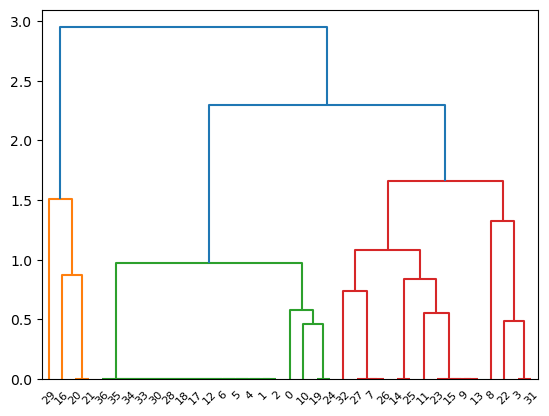

In [73]:
reparome_profile_dists['Klebsiella_pasteurii']
dendrogram(linkage(reparome_profile_dists['Klebsiella_pasteurii'], method='complete'))

In [80]:
import fastcluster

linkage(reparome_profile_dists['Klebsiella_pasteurii'], method='single', nystroem_sampling_ratio=0.1)

dendrogram(linkage(reparome_profile_dists['Klebsiella_pasteurii'], method='complete'))

TypeError: linkage() got an unexpected keyword argument 'nystroem_sampling_ratio'

In [81]:
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1-D condensed distance matrix
    or a 2-D array of observation vectors.
    
    If y is a 1-D condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector, where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents t

cluster                                             gNdaGGRC_30430  \
haplo_index                                                      1   
haplo_sequence                               ----------------atgac   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  1   
                      573.12859                                  1   
                      573.12860                                  1   
                      573.12861                                  1   
                      573.12862                                  1   
...                                                            ...   
                      GCF_929618865.1_cpe058                     1   
                      GCF_929618875.1_cpe010                     1   
                      GCF_929618885.1_cpe070                     1   
                      GCF_929618965.1_cpe027                     1   
                      GCF_929620255.1_cpe033                     1   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtaaagctctcgttttc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
                      GCF_929618885.1_cpe070                     0   
                      GCF_929618965.1_cpe027                     0   
                      GCF_929620255.1_cpe033                     0   

cluster                                                             \
haplo_index                                                          
haplo_sequence                               atgggtagagctctcgttatc   
species               genome_id                                      
Klebsiella_pneumoniae 573.12858                                  0   
                      573.12859                                  0   
                      573.12860                                  0   
                      573.12861                                  0   
                      573.12862                                  0   
...                                                            ...   
                      GCF_929618865.1_cpe058                     0   
                      GCF_929618875.1_cpe010                     0   
       

In [157]:
# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN


# # Create a DBSCAN object
# dbscan = DBSCAN(eps=0.3, min_samples=10)

# # Fit the model to the data
# labels = dbscan.fit_predict(reparome_haplotypes_genome_dists['Klebsiella_pneumoniae'])

# Create a TSNE object
# tsne = TSNE(n_components=2, init='pca', n_jobs=4, learning_rate='auto')

# Fit the model to the data
# X_tsne = tsne.fit_transform(reparome_haplotypes_genome_dists['Klebsiella_pneumoniae'])


# temp = (
#     pd.DataFrame(
#         X_tsne,
#         columns=['Dim 1', 'Dim 2'],
#     )
#     .assign(color = labels)
# )

# sns.scatterplot(temp,x='Dim 1', y='Dim 2', hue='color', palette='tab10')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

eps_values = np.linspace(0.1, 1, 10)
min_samples_values = range(5, 15)
best_score = float("inf")
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        num_clusters = len(np.unique(labels))
        if num_clusters <= 1:
            continue
        score = calinski_harabasz_score(X, labels)
        bic = BIC(X, labels, num_clusters, score)
        if bic < best_score:
            best_score = bic
            best_eps = eps
            best_min_samples = min_samples

,0,1
0,0.1,10.0
1,0.2,10.0
2,0.3,10.0
3,0.4,10.0
4,0.5,10.0
...,...,...
195,0.6,200.0
196,0.7,200.0
197,0.8,200.0
198,0.9,200.0


# Clustering by gene content

## Imports

In [235]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt


## Helpers

In [170]:
def expand_kegg_record(json_obj):
    paths = []
    def dfs(node, path):
        if not node.get("children"):
            paths.append(path + [node["name"]])
            return
        for child in node["children"]:
            dfs(child, path + [node["name"]])
    dfs(json_obj, [])
    return paths

### Reading Kegg KO data for DNA repair for prokaryotes

In [174]:
recs = expand_kegg_record(json.loads('\n'.join(run_in_shell('cat', '/home/hugo.avila/Projects/reparoma/data/reparoma/kegg/ko03400.json')))['children'][1])

kegg_KO_proka = (
    pd.DataFrame([ rec + ([None] * (6 - len(recs))) for rec in recs ])
    .iloc[:, 1:]
    .fillna('')
    .assign(
        KO = lambda df_: df_.apply(lambda x: tuple(filter(lambda y: y.startswith('K'), x))[0], axis=1),
        cats = lambda df_: df_.apply(lambda x: list(filter(lambda y: not y.startswith('K'), x)), axis=1),
    )
    .loc[:, ['cats', 'KO']]
    .pipe(lambda df_: pd.concat((pd.DataFrame(df_.cats.values.tolist()), df_.KO), axis=1, ignore_index=True) )
    .assign(
        KO = lambda df_: df_[4].str.split().str[0],
        name = lambda df_: df_[4].str.split(';').str[0].str.split().apply(lambda x: ' '.join(x[1:])),
        description = lambda df_: df_[4].str.split(';').str[1],
        categorie = lambda df_: df_.loc[:, :3].agg('; '.join, axis=1)
    )
    .loc[:, lambda df_: ~df_.columns.to_series().str.isdigit().apply(bool) ]
)

kegg_KO_proka

,KO,name,description,categorie
0,K00567,"ogt, MGMT",methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
1,K10778,ada,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
2,K13530,adaA,"AraC family transcriptional regulator, regula...",SSBR (single strand breaks repair); Direct rep...
3,K13531,adaB,methylated-DNA-[protein]-cysteine S-methyltra...,SSBR (single strand breaks repair); Direct rep...
4,K01669,"phr, PHR1",deoxyribodipyrimidine photo-lyase [EC:4.1.99.3],SSBR (single strand breaks repair); Direct rep...
...,...,...,...,...
152,K01520,"dut, DUT",dUTP pyrophosphatase [EC:3.6.1.23],Other factors with a suspected DNA repair func...
153,K00525,"E1.17.4.1A, nrdA, nrdE",ribonucleoside-diphosphate reductase alpha ch...,Other factors with a suspected DNA repair func...
154,K00526,"E1.17.4.1B, nrdB, nrdF",ribonucleoside-diphosphate reductase beta cha...,Other factors with a suspected DNA repair func...
155,K06881,nrnA,bifunctional oligoribonuclease and PAP phosph...,Other factors with a suspected DNA repair func...


### loading the presence absence of the clusters in the pangenomes

In [185]:
pres_abs_df = (
    pd.read_pickle('/home/hugo.avila/Projects/reparoma/results/ppanggolin/reps/PRES_ABS_GENUS.pkl')
)

pres_abs_df.head()

species             Klebsiella_grimontii                              \
genome_ids     GCF_000427015.1_kleoxysa2 GCF_001052235.1_ASM105223v1   
genus_clusters                                                         
Ip6VPycV_48830                     False                       False   
Ip6VPycV_49470                     False                       False   
tU8ghtab_60870                     False                       False   
Ip6VPycV_50110                     False                       False   
Ip6VPycV_50430                     False                       False   

species                                                                 \
genome_ids     GCF_001052825.1_ASM105282v1 GCF_001053665.1_ASM105366v1   
genus_clusters                                                           
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 \
genome_ids     GCF_001054995.1_ASM105499v1 GCF_001060405.1_ASM106040v1   
genus_clusters                                                           
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 \
genome_ids     GCF_001065765.1_ASM106576v1 GCF_001066775.1_ASM106677v1   
genus_clusters                                                           
Ip6VPycV_48830                       False                       False   
Ip6VPycV_49470                       False                       False   
tU8ghtab_60870                       False                       False   
Ip6VPycV_50110                       False                       False   
Ip6VPycV_50430                       False                       False   

species                                                                 ...  \
genome_ids     GCF_001070955.1_ASM107095v1 GCF_001072735.1_ASM107273v1  ...   
genus_clusters                                                          ...   
Ip6VPycV_48830                       False                       False  ...   
Ip6VPycV_49470                       False                       False  ...   
tU8ghtab_60870                       False                       False  ...   
Ip6VPycV_50110                       False                       False  ...   
Ip6VPycV_50430                       False                       False  ...   

species        Klebsiella_variicola                                          \
genome_ids                573.13358 573.13419 573.13484 573.13647 573.13649   
genus_clusters                                                                
Ip6VPycV_48830                False     False     False     False     False   
Ip6VPycV_49470                False     False     False     False     False   
tU8ghtab_60870                 True     False     False     False     False   
Ip6VPycV_50110                False     False     False     False     False   
Ip6VPycV_50430                 True     False     False     False     False   

species                                                           
genome_ids     573.14059 573.14170 573.14328 573.14387 573.14410  
genus_clusters                                                    
Ip6VPycV_48830     False     False     False     False     False  
Ip6VPycV_49470     False     False     False     False     False  
tU8ghtab_60870     False     False     Fals

### Reading the Kofam results 

In [178]:
kofamkoala_results = (
    # Reading the results table
    pd.read_csv(
        '/home/hugo.avila/Projects/reparoma/results/GOIs/reparome/kofamkoala.tsv',
        sep='\t',
        header=None,
        names=('locus_tag', 'KO')
    )
    # Getting only the matchs within ko03400
    .loc[lambda df_: df_.KO.isin(kegg_KO_proka.KO)]
)

kofamkoala_results.head()

,locus_tag,KO
0,00SnrgcH_46610,K03701
1,00oLeWUr_30690,K05984
2,03Ohzhgj_10620,K03502
3,03Ohzhgj_27860,K03724
5,0CF6qbmi_49810,K03746


### Cluster based on presence absence reparome clusters genes

Get a presecense absence matrix for the reparoma gene clusters then get the jaccard similarity between the genomes. 

In [197]:
reparome_genes = (
    pres_abs_df
    # get only reparome genes
    .loc[lambda df_: df_.index.isin(kofamkoala_results.locus_tag)]
    .T
)

reparome_genes

genus_clusters                                    r4WE3k6E_23700  \
species              genome_ids                                    
Klebsiella_grimontii GCF_000427015.1_kleoxysa2             False   
                     GCF_001052235.1_ASM105223v1           False   
                     GCF_001052825.1_ASM105282v1           False   
                     GCF_001053665.1_ASM105366v1           False   
                     GCF_001054995.1_ASM105499v1           False   
...                                                          ...   
Klebsiella_variicola 573.14059                              True   
                     573.14170                              True   
                     573.14328                              True   
                     573.14387                              True   
                     573.14410                              True   

genus_clusters                                    ebffPcMY_39430  \
species              genome_ids                                    
Klebsiella_grimontii GCF_000427015.1_kleoxysa2              True   
                     GCF_001052235.1_ASM105223v1            True   
                     GCF_001052825.1_ASM105282v1            True   
                     GCF_001053665.1_ASM105366v1            True   
                     GCF_001054995.1_ASM105499v1            True   
...                                                          ...   
Klebsiella_variicola 573.14059                              True   
                     573.14170                              True   
                     573.14328                              True   
                     573.14387                              True   
                     573.14410                              True   

genus_clusters                                    q1XgciBx_30530  \
species              genome_ids                                    
Klebsiella_grimontii GCF_000427015.1_kleoxysa2             False   
                     GCF_001052235.1_ASM105223v1           False   
                     GCF_001052825.1_ASM105282v1           False   
                     GCF_001053665.1_ASM105366v1           False   
                     GCF_001054995.1_ASM105499v1           False   
...                                                          ...   
Klebsiella_variicola 573.14059                             False   
                     573.14170                             False   
                     573.14328                             False   
                     573.14387                             False   
                     573.14410                             False   

genus_clusters                                    2Y2KCq6A_00810  \
species              genome_ids                                    
Klebsiella_grimontii GCF_000427015.1_kleoxysa2             False   
                     GCF_001052235.1_ASM105223v1           False   
                     GCF_001052825.1_ASM105282v1           False   
                     GCF_001053665.1_ASM105366v1           False   
                     GCF_001054995.1_ASM105499v1           False   
...                                                          ...   
Klebsiella_variicola 573.14059                             False   
                     573.14170                             False   
                     573.14328                             False   
                     573.14387                             False   
                     573.14410                             False   

genus_clusters                                    7FAfyIu6_12890  \
species              genome_ids                                    
Klebsiella_grimontii GCF_000427015.1_kleoxysa2             False   
                     GCF_001052235.1_ASM105223v1           False   
                     GCF_001052825.1_ASM105282v1           False   
                     GCF_001053665.1_ASM105366v1           False   
                     GCF_001054995.1_ASM105499v1    

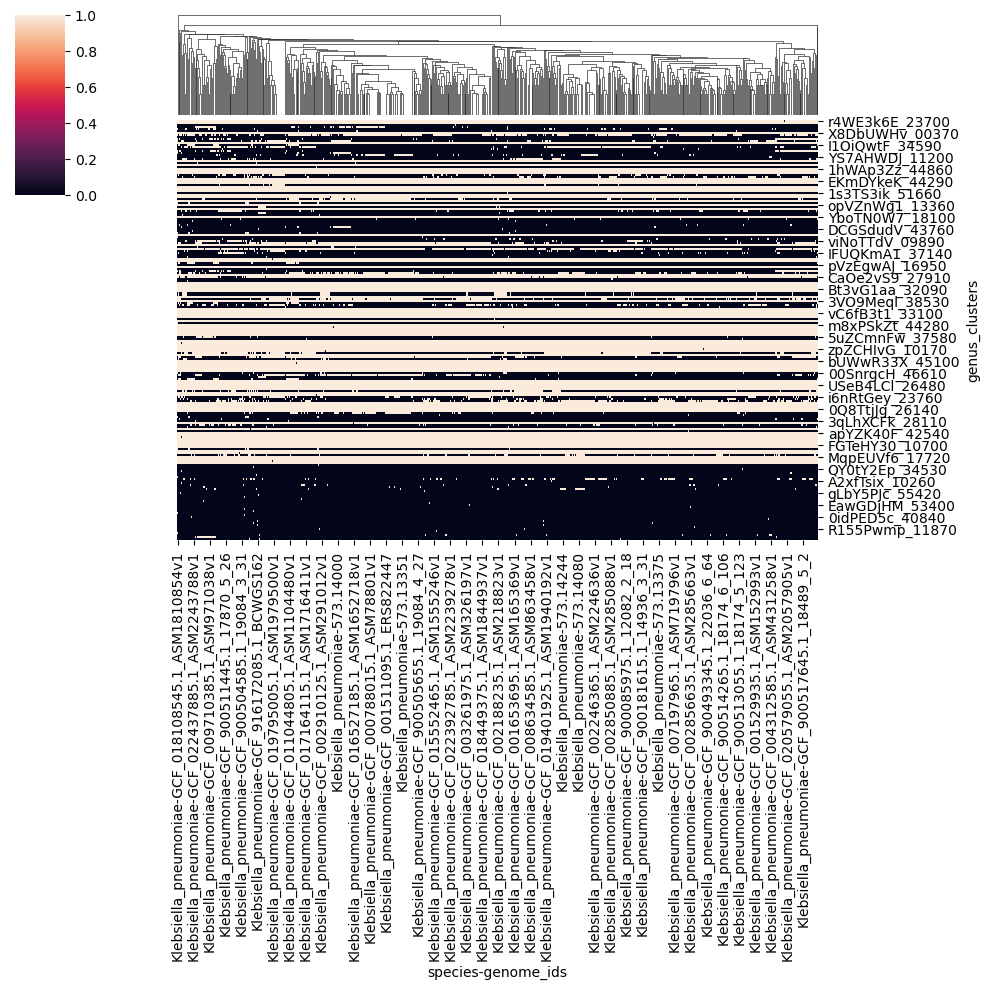

In [268]:
temp = (
        reparome_genes[lambda df_: df_.index.get_level_values('species').to_series().eq('Klebsiella_pneumoniae').values]
        .sample(frac=.05)
        .loc[:, lambda df_: df_.any()]
)

sns.clustermap(
    temp.T,
    row_cluster=False,
)

In [238]:
temp = (
    reparome_genes[lambda df_: df_.index.get_level_values('species').to_series().eq('Klebsiella_grimontii').values]
    .loc[:, lambda df_: df_.any()]
)

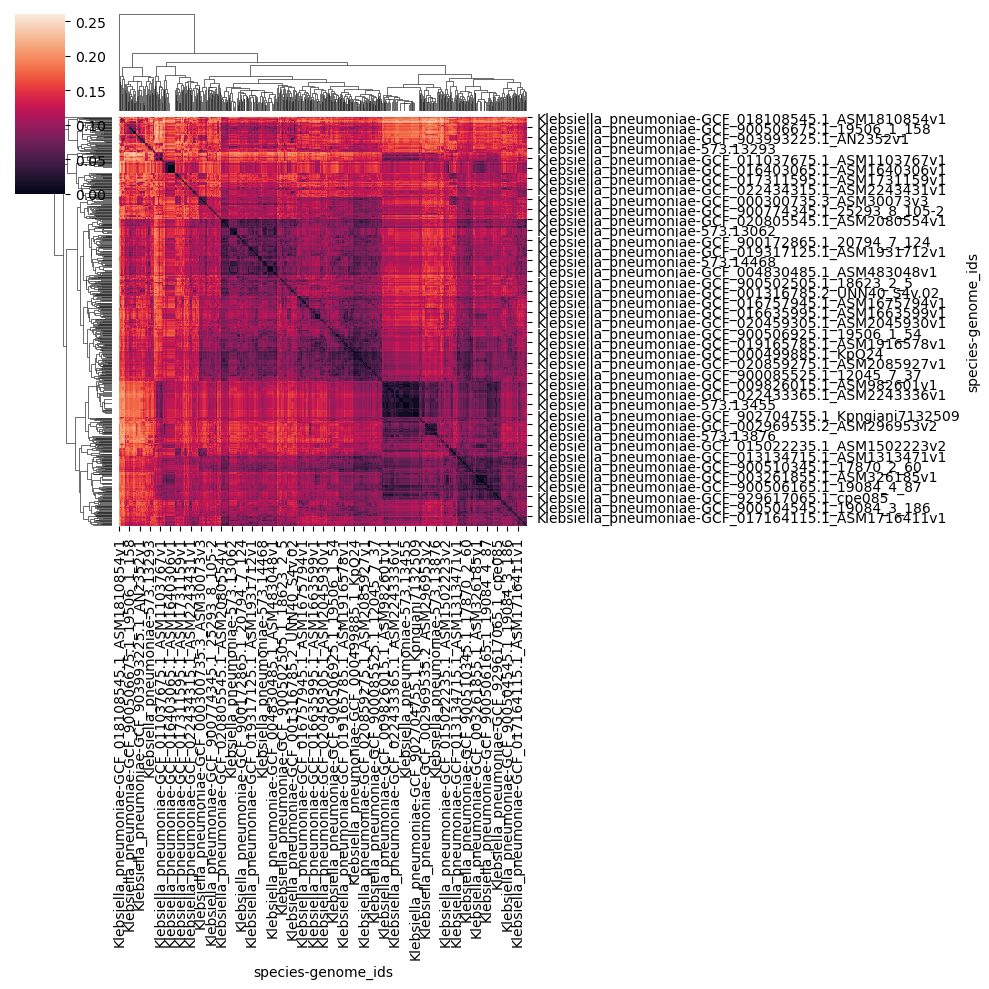

In [285]:
from scipy.spatial.distance import pdist, squareform

def get_jaccard_dist_matrix(df):
    return (
        pd.DataFrame(
            squareform(pdist(temp, metric='jaccard')),
            index=df.index,
            columns=df.index
        )
    )

sns.clustermap(get_jaccard_dist_matrix(temp))



# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN


# # Create a DBSCAN object
# dbscan = DBSCAN(eps=0.3, min_samples=10)

# # Fit the model to the data
# labels = dbscan.fit_predict(reparome_haplotypes_genome_dists['Klebsiella_pneumoniae'])

# Create a TSNE object
# tsne = TSNE(n_components=2, init='pca', n_jobs=4, learning_rate='auto')

# Fit the model to the data
# X_tsne = tsne.fit_transform(reparome_haplotypes_genome_dists['Klebsiella_pneumoniae'])


# temp = (
#     pd.DataFrame(
#         X_tsne,
#         columns=['Dim 1', 'Dim 2'],
#     )
#     .assign(color = labels)
# )

# sns.scatterplot(temp,x='Dim 1', y='Dim 2', hue='color', palette='tab10')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

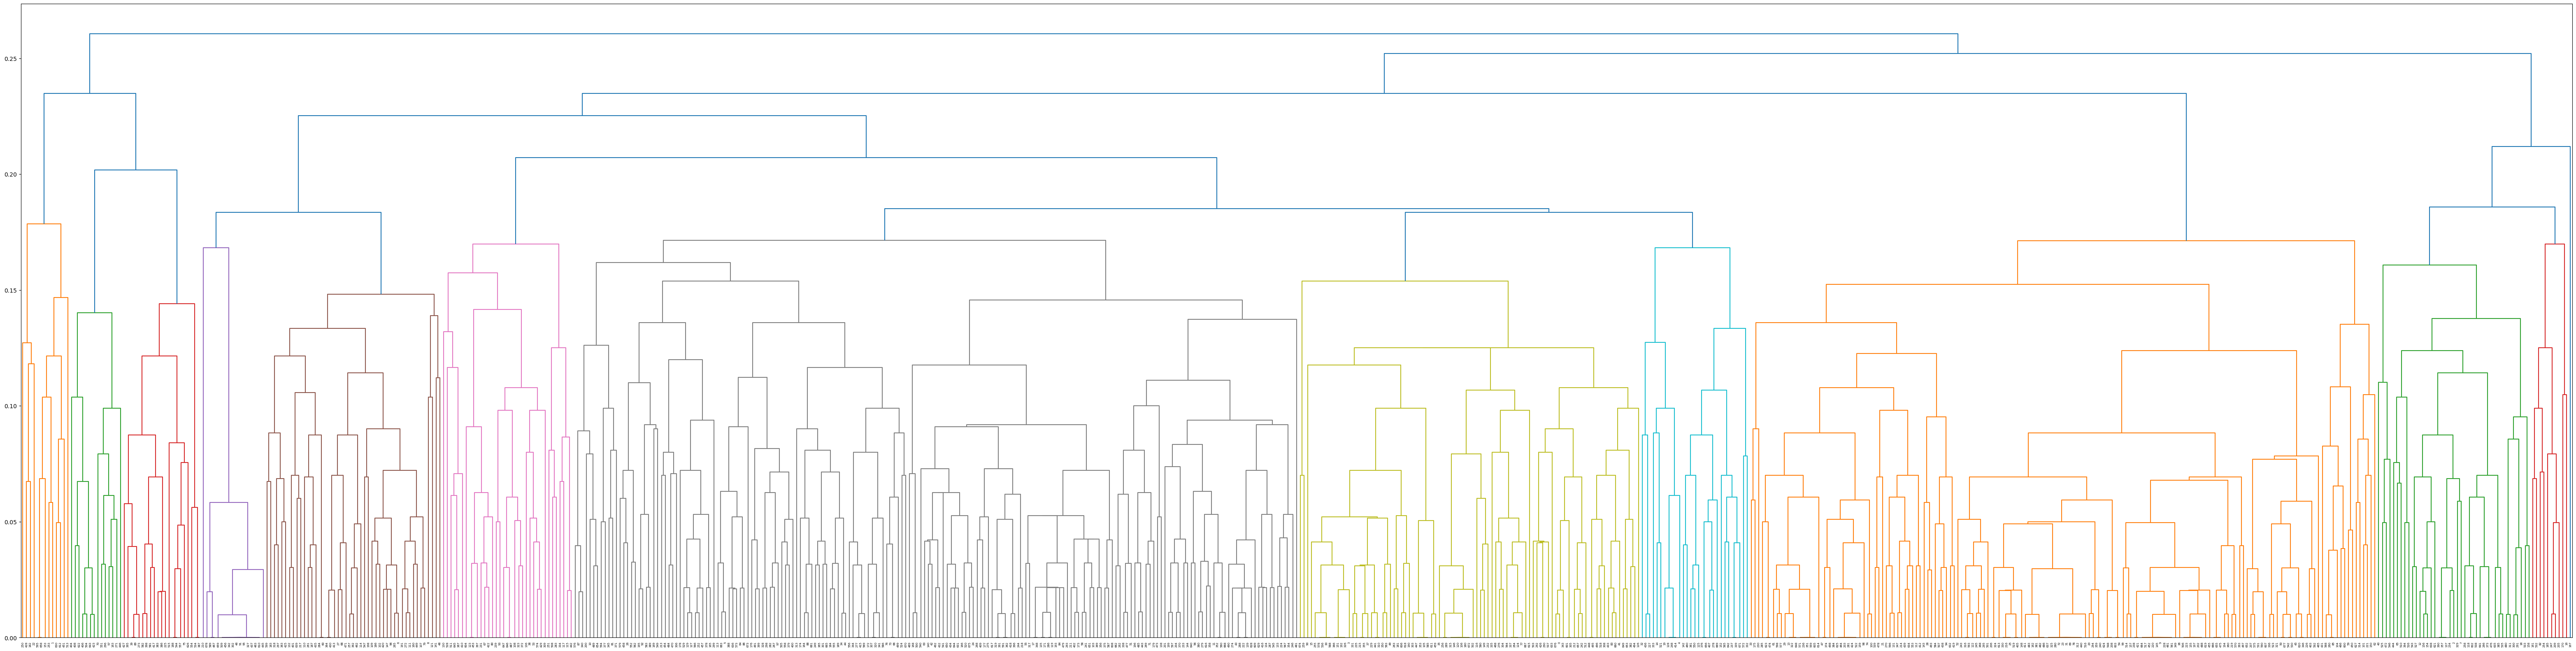

In [305]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(temp, method='complete', metric='jaccard', optimal_ordering=True)
fig = plt.figure(figsize=(80, 20))
dn = dendrogram(Z)



In [302]:
import ete3

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [30.0, 30.0, 52.5, 52.5],
  [15.0, 15.0, 41.25, 41.25],
  [5.0, 5.0, 28.125, 28.125],
  [85.0, 85.0, 95.0, 95.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [90.0, 90.0, 112.5, 112.5],
  [75.0, 75.0, 101.25, 101.25],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [142.5, 142.5, 172.5, 172.5],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [195.0, 195.0, 212.5, 212.5],
  [157.5, 157.5, 203.75, 203.75],
  [88.125, 88.125, 180.625, 180.625],
  [16.5625, 16.5625, 134.375, 134.375],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [265.0, 265.0, 275.0, 275.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [295.0, 295.0, 312.5, 312.5],
  [285.0, 285.0, 303.75, 303.75],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [335

In [303]:
temp

genus_clusters                                      r4WE3k6E_23700  \
species               genome_ids                                     
Klebsiella_pneumoniae GCF_003574235.1_ASM357423v1             True   
                      GCF_008867705.1_ASM886770v1             True   
                      GCF_900516305.1_18174_8_112             True   
                      573.13356                               True   
                      GCF_009935695.1_ASM993569v1             True   
...                                                            ...   
                      GCF_001482645.1_ASM148264v1             True   
                      GCF_900180505.1_14936_3_84              True   
                      GCF_002055855.1_ASM205585v1             True   
                      GCF_002182065.1_ASM218206v1             True   
                      GCF_021398425.1_ASM2139842v1            True   

genus_clusters                                      ebffPcMY_39430  \
species               genome_ids                                     
Klebsiella_pneumoniae GCF_003574235.1_ASM357423v1             True   
                      GCF_008867705.1_ASM886770v1             True   
                      GCF_900516305.1_18174_8_112             True   
                      573.13356                               True   
                      GCF_009935695.1_ASM993569v1             True   
...                                                            ...   
                      GCF_001482645.1_ASM148264v1             True   
                      GCF_900180505.1_14936_3_84              True   
                      GCF_002055855.1_ASM205585v1             True   
                      GCF_002182065.1_ASM218206v1             True   
                      GCF_021398425.1_ASM2139842v1            True   

genus_clusters                                      q1XgciBx_30530  \
species               genome_ids                                     
Klebsiella_pneumoniae GCF_003574235.1_ASM357423v1            False   
                      GCF_008867705.1_ASM886770v1            False   
                      GCF_900516305.1_18174_8_112            False   
                      573.13356                              False   
                      GCF_009935695.1_ASM993569v1            False   
...                                                            ...   
                      GCF_001482645.1_ASM148264v1            False   
                      GCF_900180505.1_14936_3_84             False   
                      GCF_002055855.1_ASM205585v1            False   
                      GCF_002182065.1_ASM218206v1            False   
                      GCF_021398425.1_ASM2139842v1           False   

genus_clusters                                      2Y2KCq6A_00810  \
species               genome_ids                                     
Klebsiella_pneumoniae GCF_003574235.1_ASM357423v1            False   
                      GCF_008867705.1_ASM886770v1            False   
                      GCF_900516305.1_18174_8_112            False   
                      573.13356                              False   
                      GCF_009935695.1_ASM993569v1            False   
...                                                            ...   
                      GCF_001482645.1_ASM148264v1            False   
                      GCF_900180505.1_14936_3_84             False   
                      GCF_002055855.1_ASM205585v1            False   
                      GCF_002182065.1_ASM218206v1             True   
                      GCF_021398425.1_ASM2139842v1           False   

genus_clusters                                      7FAfyIu6_12890  \
species               genome_ids                                     
Klebsiella_pneumoniae GCF_003574235.1_ASM357423v1             True   
                      GCF_008867705.1_ASM886770v1            False   
                      GCF_900516305.1_18174_8_112            False   
      

In [306]:
! pip install plotly